# Eksperimen

Kode Skripsi Nathasya E (2021)

## Table of Contents
- [Preparation](#Preparation)
- [Observasi Awal](#Observasi_Awal)
- [Eksperimen Pendahuluan](#Eksperimen_Pendahuluan)
    - [Wavelength 400-800nm](#a.Wavelength_400-800nm)
    - [Wavelength 400-1000nm](#b.Wavelength_400-1000nm)
- [Eksperimen Utama](#Eksperimen_Utama)
    - [3 Tinta](#a.3_Tinta)
    - [10 Tinta](#b.10_Tinta)
- [Export](#Export)

## Concept
> hyperspectral img -> normalize -> no dimensionality reduction/PCA/t-SNE -> k-means clustering -> manually label clusters -> evaluate metrics -> analysis

hasil k-means clustering di-export dan langkah-langkah selanjutnya dilanjutkan secara manual menggunakan excel

# Preparation

In [4]:
from sklearn.manifold import TSNE
import collections
from sklearn.cluster import KMeans
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import umap.umap_ as umap
import plotly.express as px
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
from plantcv import plantcv as pcv
import spectral as sp
import cv2

In [37]:
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola
from skimage import io
from time import time

In [163]:
'''
Functions for preparation
'''

def sauvola_masking(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    window_size = 25
    thresh_sauvola = threshold_sauvola(image, window_size=window_size)
    binary_sauvola = image > thresh_sauvola

    return binary_sauvola


def roi_to_df(image, mask, label):
    shape = image.shape
    
    x_arr = []
    y_arr = []
    val_arr = []
    label_arr = []
    
    # populate x, y
    for x in range(shape[0]):
        for y in range(shape[1]):
            if (mask[x][y]==False):
                x_arr.append(x)
                y_arr.append(y)
                val_arr.append(image[x][y])
                label_arr.append(label)
    
    df = pd.DataFrame(data = val_arr)
    df.columns+=1
    df.insert(0,'x',x_arr)
    df.insert(1,'y',y_arr)
    df.insert(2, 'label', label_arr)
    
    return df

def extract(ystart, yend, img_src, rgb_src, label):
    '''
    extract ROI
    '''
    
    result_img = img_src.copy()[ystart:yend,]
    result_rgb = rgb_src.copy()[ystart:yend,]
    
    mask = sauvola_masking(result_rgb)
    
    df = roi_to_df(result_img, mask, label)
    
    return result_img, result_rgb, mask, df

def masking():
    return None

In [588]:
'''
Function for visualizations
'''

def plot_dots(df, target="label", mode="pca", opacity=0.3, large="off", title="Plot", axis="square", size=""):
    xval="principal component 1"
    yval="principal component 2"
    
    if(mode=="tsne"):
        xval="dimension 1"
        yval="dimension 2"
    elif(mode=="basic"):
        xval="x"
        yval="y"
    
    if(size!=""):
        plt.figure(figsize=size)
    else:
        plt.axis(axis)
    plt.title(title)
    
    sns.scatterplot(
        x=xval, y=yval,
        hue=target,
        data=df,
        palette="tab10",
        legend="full",
        alpha=opacity
    )
    plt.legend(title=target,loc='upper left', bbox_to_anchor=(1.05, 1))

def adjust_index(df, intervals, labels, direction="vertical", target="cluster"):
    # notes: x (vertical up to bottom) & y (horizontal, left to right)
    
    df_adjusted = df.copy().reset_index()

    if(direction=="vertical"):
        sumbu = 'x'
    else:
        sumbu = 'y'
        
    for i in range(len(intervals)):
        df_adjusted.loc[df_adjusted.label == labels[i+1], [sumbu]] += (intervals[i])
        
        
    df_adjusted[target] = df.reset_index()[target]

    return df_adjusted

def visualize_on_image(df, mask, target='cluster', axis='off', tipe="10 tinta", labels=[i for i in range(1,11)]):
    
    df = df.copy()
    
    if(tipe=="3 tinta"):
        intervals = [120,350]
        direction = "horizontal"
    elif(tipe=="10 tinta"):
        intervals = [100, 300, 450, 650, 800, 1000, 1150, 1300, 1480]
        direction = "vertical"
    
    df_adjusted = adjust_index(df, intervals, labels, direction, target)
    
    picture = np.full((mask.shape[0],mask.shape[1],3), (1.0, 1.0, 1.0))
    
    for index, row in df_adjusted.iterrows():
        if(target=='cluster'):
            idx_color = int(row[target])
        elif(target=='label'):
            idx_color = int(row[target])-1
        picture[int(row['x']), int(row['y'])] = sns.color_palette()[idx_color]
    
    plt.imshow(picture)
    plt.axis(axis)
    
    return picture

In [478]:
'''
Function for dimensionality reduction & clustering
'''

def prepare_df(df, mode="full"):    
    if(mode=="sebagian"):
        df = df.copy().iloc[:,:125]
    return df

def pca(df_src, n=2, rand=0, mode="full"):
    # setting
    t0 = time()
    
    df = prepare_df(df_src, mode)
    
    # PCA
    pca = PCA(n_components=n)
    pca_result = pca.fit_transform(df.drop([i for i in df.columns if isinstance(i, str)], axis=1))
    df_pca = pd.DataFrame(data = pca_result, columns = ['principal component '+ str(i+1) for i in range(n)])
    df_pca['label'] = df.copy().reset_index()['label']
     
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    print('Cumulative variance explained by {} principal components: {:.2%}'.format(n, np.sum(pca.explained_variance_ratio_)))
    
    print("Time PCA " + str(time() - t0))
       
    return df_pca

def tsne(df_src, n=2, rand=0, mode="full", p=5, init_mode="pca", niter=1000):
    # setting
    t0 = time()
    
    df = prepare_df(df_src, mode)
    
    # t-SNE
    tsne_result = TSNE(n_components=n, init=init_mode, random_state=0, perplexity=p, n_iter=niter, verbose=1).fit_transform(df.drop([i for i in df.columns if isinstance(i, str)], axis=1))
    df_result = pd.DataFrame(data = tsne_result, columns = ['dimension 1', 'dimension 2'])
    df_result['label'] = df.copy().reset_index()['label']
    
    print("Time t-SNE " + str(time() - t0))
    
    return df_result

def kmeans(df, k=10, rand=0):
    kmeans = KMeans(n_clusters=k, random_state=rand).fit(df)
    df['cluster']= kmeans.labels_
    return df

In [505]:
def reduce_to_2d(df, p=5, niter=1000):
    df = df.copy().reset_index()
    
    df_tsne = tsne(df, n=2, p=p, niter=niter)
    df_pca = pca(df, n=2)
    
    df['principal component 1'] = df_pca['principal component 1']
    df['principal component 2'] = df_pca['principal component 2']
    df['dimension 1'] = df_tsne['dimension 1']
    df['dimension 2'] = df_tsne['dimension 2']
    
    return df

In [11]:
def color_check(numbers):
    plt.imshow(np.full((5,5,3), numbers))

In [600]:
# start import and preprocessing data

In [10]:
hdr = sp.envi.open("blues_1_29_VNIR_1800_2029.hdr")
wvl = hdr.bands.centers
rows, cols, bands = hdr.nrows, hdr.ncols, hdr.nbands
meta = hdr.metadata

img = hdr.load()

# to make it not an imagearray
img = img.copy()[:,:,:]

rgb = cv2.cvtColor(cv2.imread('srgb.jpg'), cv2.COLOR_BGR2RGB)

In [12]:
# normalize

xx = img.copy()

xxmax, xxmin = xx.max(), xx.min()
xx = (xx - xxmin)/(xxmax - xxmin)
img = xx

In [13]:
ystarts = [0, 150, 300, 450, 650, 800, 1000, 1150, 1350, 1480]
yends = [100, 300, 450, 650, 800, 1000, 1150, 1300, 1480, 1594]

labels = ['Tinta 1','Tinta 2','Tinta 3','Tinta 4','Tinta 5','Tinta 6','Tinta 7','Tinta 8','Tinta 9','Tinta 10']

In [14]:
rgbs = []
imgs = []
masks = []
dfs = []

for i in range(10):
    imgx, rgbx, maskx, dfx = extract(ystarts[i], yends[i], img.copy(), rgb.copy(), i+1)
    imgs.append(imgx)
    rgbs.append(rgbx)
    masks.append(maskx)
    dfs.append(dfx)

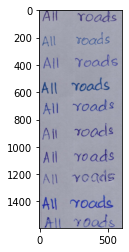

In [15]:
plt.imshow(rgb)

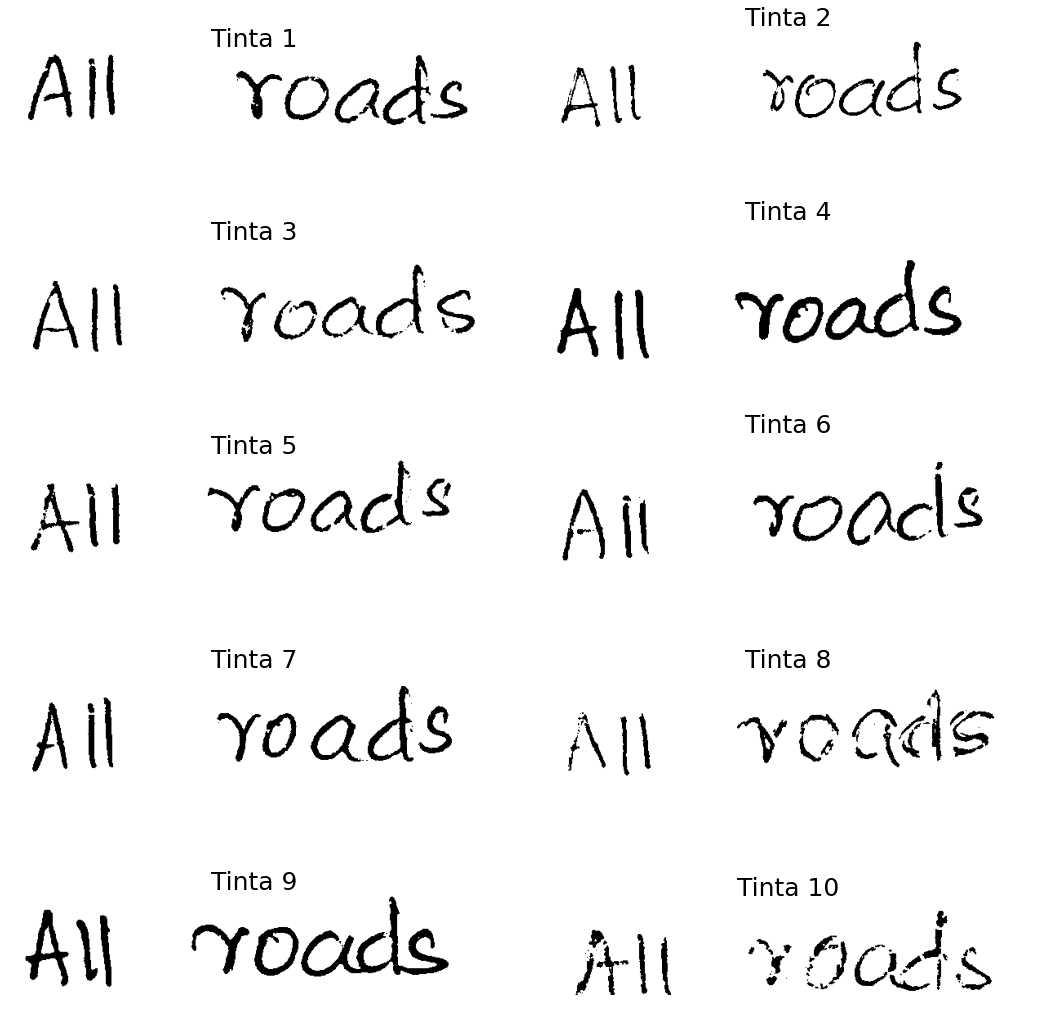

In [16]:
fig, axs = plt.subplots(5, 2, figsize=(15,15))
fig.tight_layout()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(masks[i],cmap='gray')
    ax.set_title('Tinta ' + str(i+1), fontsize=25)
    ax.axis('off')

In [17]:
# make df 10 ink

df_10ink = dfs[0].copy()

for i in range(1,10):
    df_10ink = df_10ink.append(dfs[i])

In [18]:
def bar_10ink(df):
    plotdata = pd.DataFrame(index=['tinta ' + str(i) for i in range(1,11)], columns=['cluster ' + str(i) for i in range(1,11)])

    for i in range(1,11):
        dicti = collections.Counter(df[df.label==i]['cluster'])
        arr = []

        for j in range(10):
            if(j not in dicti.keys()):
                arr.append(0)
            else:
                arr.append(dicti[j])

        print(arr)

        plotdata.loc['tinta '+str(i)] = arr


    plt.figure(figsize=(200,50))
    plotdata.plot(kind="bar")
    plt.title("Komposisi Tinta")
    plt.xlabel("Tinta")
    plt.ylabel("Jumlah Cluster")
    
    return plotdata

In [19]:
def bar_10ink_cluster(df):
    plotdata = pd.DataFrame(index=['cluster ' + str(i) for i in range(1,11)], columns=['tinta ' + str(i) for i in range(1,11)])

    for i in range(10):
        dicti = collections.Counter(df[df.cluster==i]['label'])
        arr = []

        for j in range(10):
            if(j not in dicti.keys()):
                arr.append(0)
            else:
                arr.append(dicti[j])

        print(arr)

        plotdata.loc['cluster '+str(i)] = arr


    plt.figure(figsize=(200,50))
    plotdata.plot(kind="bar")
    plt.title("Komposisi Tinta")
    plt.xlabel("Jumlah Tinta")
    plt.ylabel("Cluster")
    
    return plotdata

# Observasi_Awal

### visualisasi all data points

Explained variation per principal component: [0.69425593 0.14473424]
Cumulative variance explained by 2 principal components: 83.90%
Time PCA 1.2391688823699951


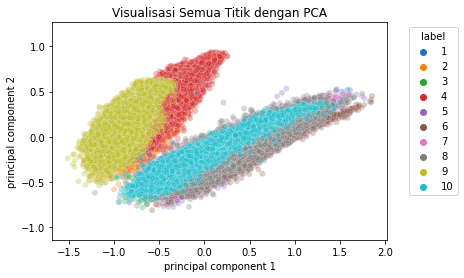

In [65]:
# visualisasi data points (PCA)

plot_dots(df_10ink, axis="equal", target="label", mode="pca", title="Visualisasi Semua Titik dengan PCA")

In [67]:
# visualisasi data points (t-SNE)

# to do
# plot_dots(df_10ink, target="label", axis="equal", mode="tsne", title="Visualisasi Semua Titik dengan t-SNE")

### observasi dari sisi spectral

In [68]:
# Koordinat 50 Titik (Tiap pts memiliki posisi yang berbeda)

# A kepala
pts = [
    (60,10),
    (45,50),
    (60,50),
    (45,85),
    (55,40),
    (50,65),
    (57,50),
    (50,55),
    (50,30),
    (65,40),
     ]

pts_2 = [
    (305, 50),
    (290, 62),
    (295, 75),
    (270, 100),
    (280, 70),
    (290, 85),
    (290, 75),
    (275, 75),
    (275, 70),
    (285, 75),
]

pts_3 = [
    (450, 55),
    (410, 75),
    (432, 80),
    (390, 100),
    (415, 60),
    (423, 85),
    (422, 70),
    (422, 75),
    (412, 70),
    (428, 67),
]

pts_4 = [
    (535, 55),
    (487, 68),
    (529, 78),
    (480, 100),
    (519, 40),
    (516, 85),
    (520, 68),
    (506, 75),
    (498, 70),
    (518, 70),
]

pts_5 = [
    (125, 40),
    (111, 68),
    (133, 78),
    (120, 100),
    (132, 50),
    (122, 85),
    (123, 68),
    (125, 75),
    (120, 70),
    (150, 70),
]

In [69]:
band_dictionary = {
    "visible-violet": {'lower': 400, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 700, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1000, 'color': 'white'}
}

def setcolor():
    for region,limits in band_dictionary.items():
        plt.axvspan(limits['lower'], limits['upper'], alpha=0.1, 
                   color=limits['color'], label=region)

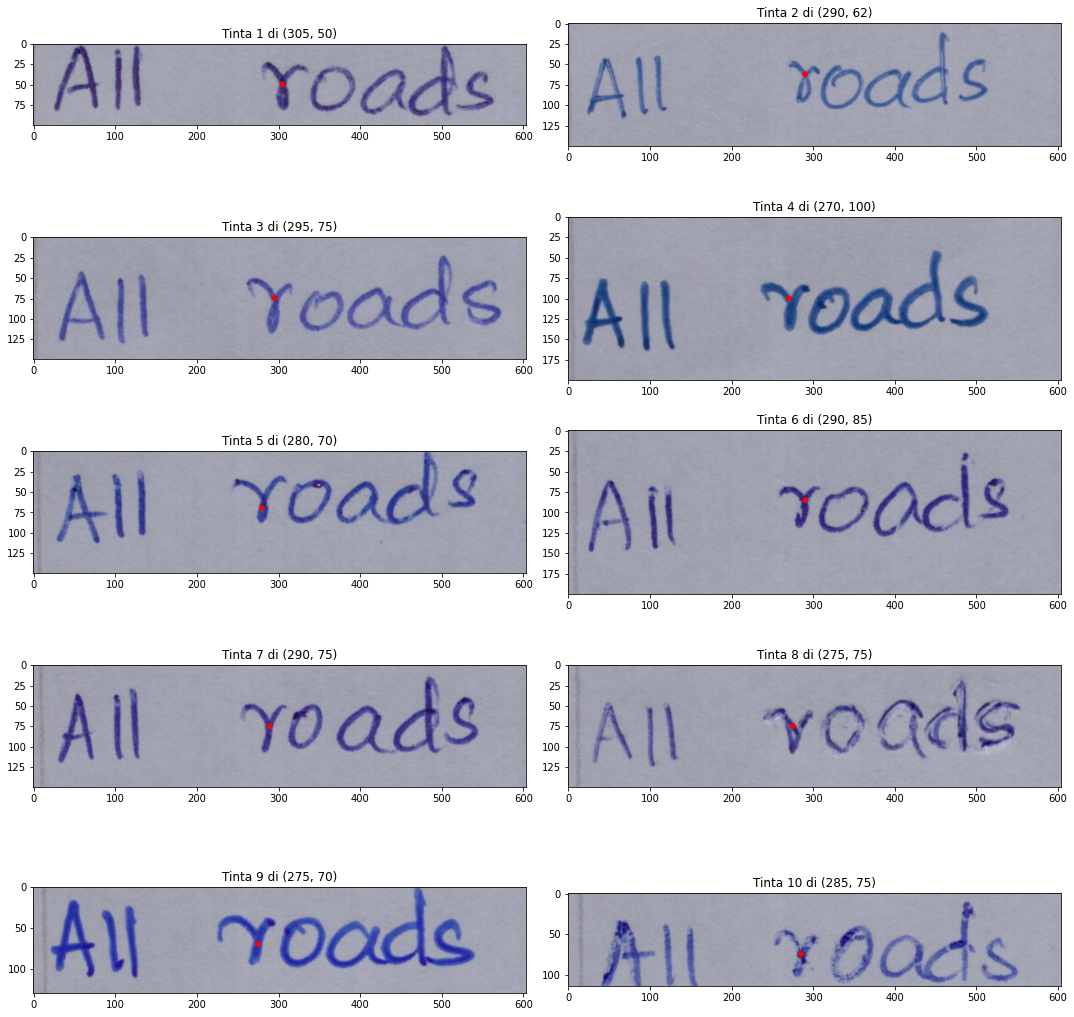

In [70]:
# cek posisi sama di tinta berbeda

fig, axs = plt.subplots(5, 2, figsize=(15,15))
fig.tight_layout()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(cv2.circle(rgbs[i].copy(), pts_2[i], 2, (255, 0, 0), 2))
    ax.set_title('Tinta ' + str(i+1) + ' di '+ str(pts_2[i]))

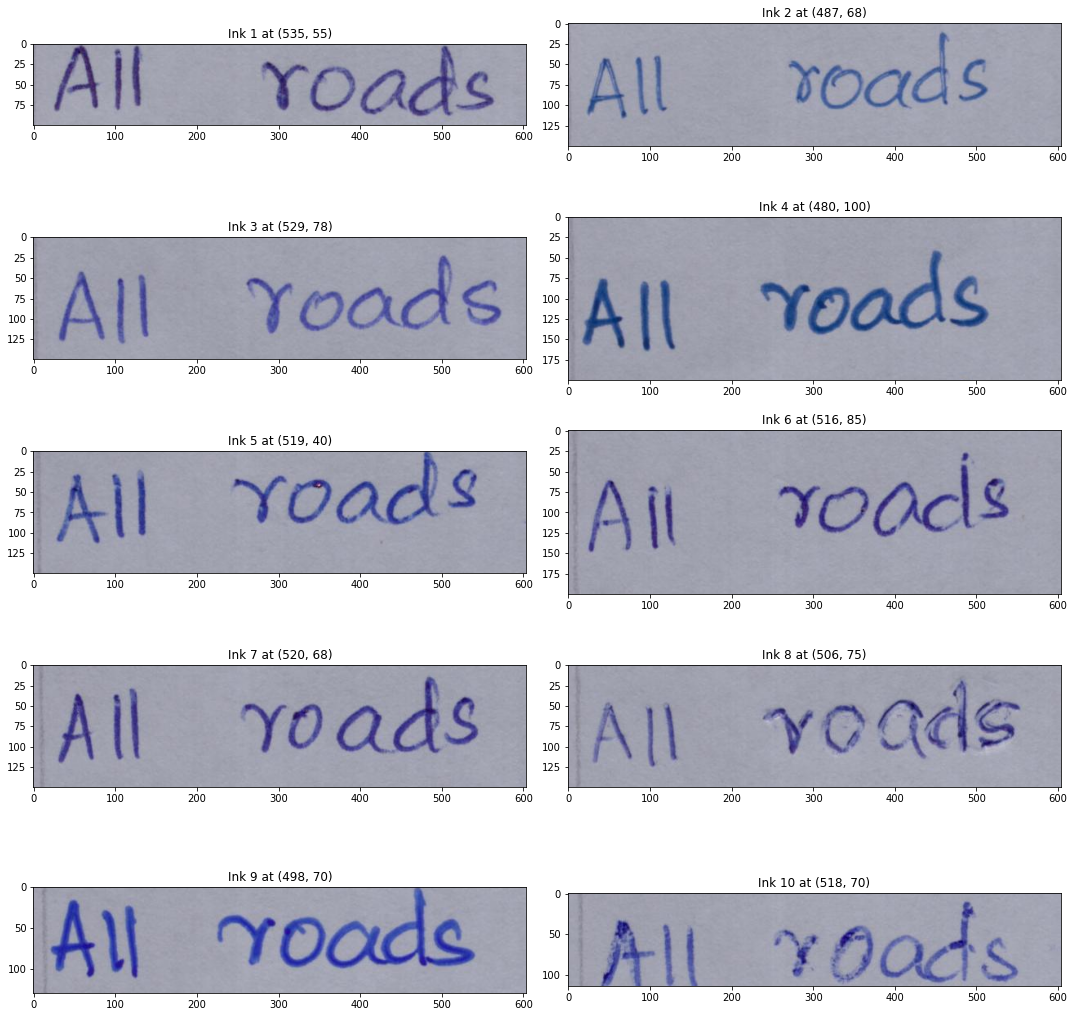

In [71]:
# 50 Titik di 10 Tinta

fig, axs = plt.subplots(5, 2, figsize=(15,15))
fig.tight_layout()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(cv2.circle(rgbs[i].copy(), (pts_4[i][1],pts_4[i][0]), 2, (255, 0, 0), 2))
    ax.set_title('Ink ' + str(i+1) + ' at '+ str(pts_4[i]))

### pts 1

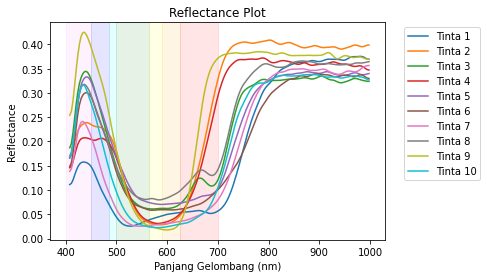

In [72]:
for i in range(10):
        plt.plot(wvl, imgs[i][pts[i][1],pts[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

### pts 2

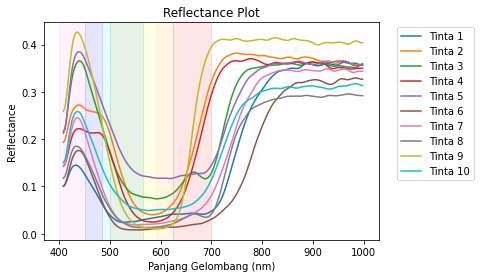

In [73]:
for i in range(10):
        plt.plot(wvl, imgs[i][pts_2[i][1],pts_2[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

### pts 3

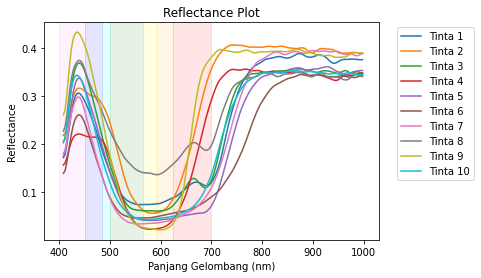

In [74]:
for i in range(10):
        plt.plot(wvl, imgs[i][pts_3[i][1],pts_3[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

### pts 4

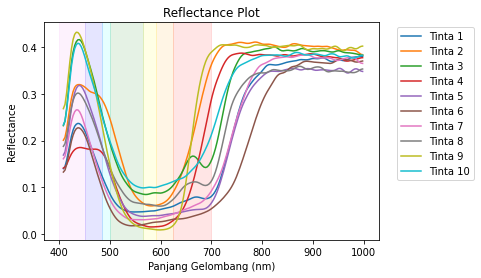

In [75]:
for i in range(10):
        plt.plot(wvl, imgs[i][pts_4[i][1],pts_4[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

### pts 5

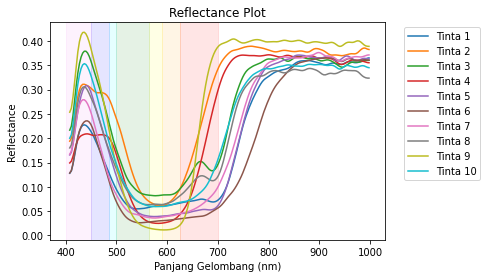

In [76]:
for i in range(10):
        plt.plot(wvl, imgs[i][pts_5[i][1],pts_5[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

### 5 titik di tinta 1

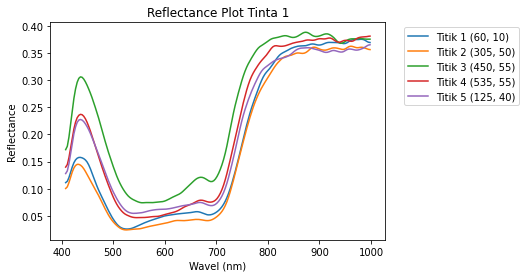

In [77]:
ptss = [pts, pts_2, pts_3, pts_4, pts_5]

for i in range(5):
    plt.plot(wvl, imgs[0][ptss[i][0][1],ptss[i][0][0]], label='Titik {} {}'.format(i+1, (ptss[i][0][0],ptss[i][0][1])))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot Tinta 1')
plt.xlabel('Wavel (nm)')
plt.ylabel('Reflectance')
plt.show()

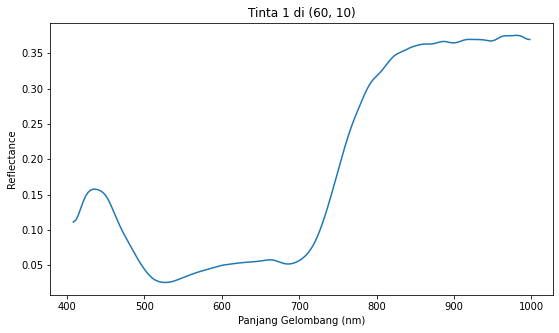

In [78]:
x = wvl
y = imgs[0][10,60]

fig, ax1 = plt.subplots(1,1, figsize=(9,5))
ax1.plot(x,y)
ax1.set_title("Tinta 1 di (60, 10)")
ax1.set_xlabel('Panjang Gelombang (nm)')
ax1.set_ylabel('Reflectance')


plt.show()

### 5 titik di tinta 2

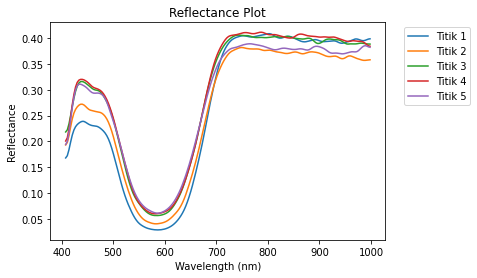

In [79]:
ptss = [pts, pts_2, pts_3, pts_4, pts_5]

for i in range(5):
    plt.plot(wvl, imgs[1][ptss[i][1][1],ptss[i][1][0]], label='Titik {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

### 5 titik di tinta 3

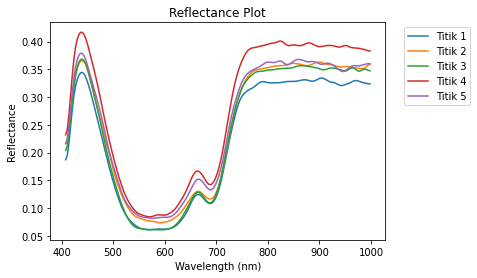

In [80]:
ptss = [pts, pts_2, pts_3, pts_4, pts_5]

for i in range(5):
    plt.plot(wvl, imgs[2][ptss[i][2][1],ptss[i][2][0]], label='Titik {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

### 5 titik di tinta 4

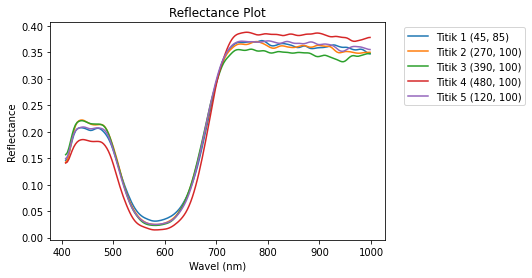

In [81]:
ptss = [pts, pts_2, pts_3, pts_4, pts_5]

for i in range(5):
    plt.plot(wvl, imgs[3][ptss[i][3][1],ptss[i][3][0]], label='Titik {} {}'.format(i+1, (ptss[i][3][0],ptss[i][3][1])))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Wavel (nm)')
plt.ylabel('Reflectance')
plt.show()

### 5 titik di tinta 5

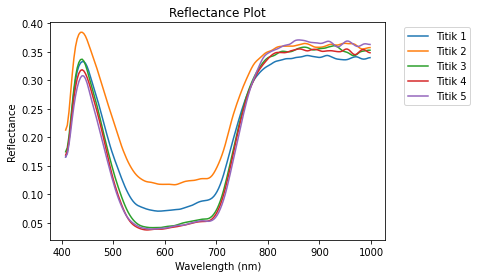

In [82]:
ptss = [pts, pts_2, pts_3, pts_4, pts_5]

for i in range(5):
    plt.plot(wvl, imgs[4][ptss[i][4][1],ptss[i][4][0]], label='Titik {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

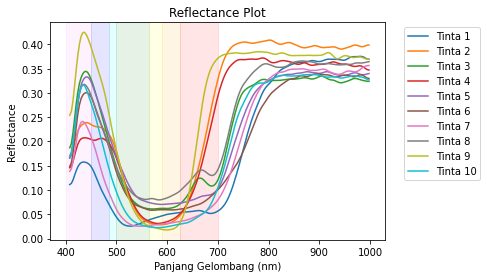

In [83]:
for i in range(10):
    plt.plot(wvl, imgs[i][pts[i][1],pts[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

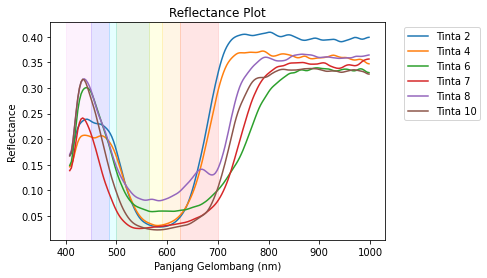

In [84]:
for i in range(10):
    if(i!=0 and i!=8 and i!=2 and i!=4):
        plt.plot(wvl, imgs[i][pts[i][1],pts[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

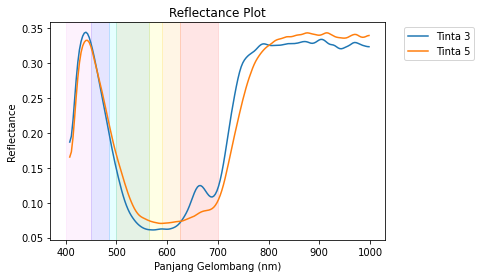

In [85]:
for i in range(10):
    if(i==2 or i==4):
        plt.plot(wvl, imgs[i][pts[i][1],pts[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
setcolor()
plt.show()

(-0.5, 603.5, 113.5, -0.5)

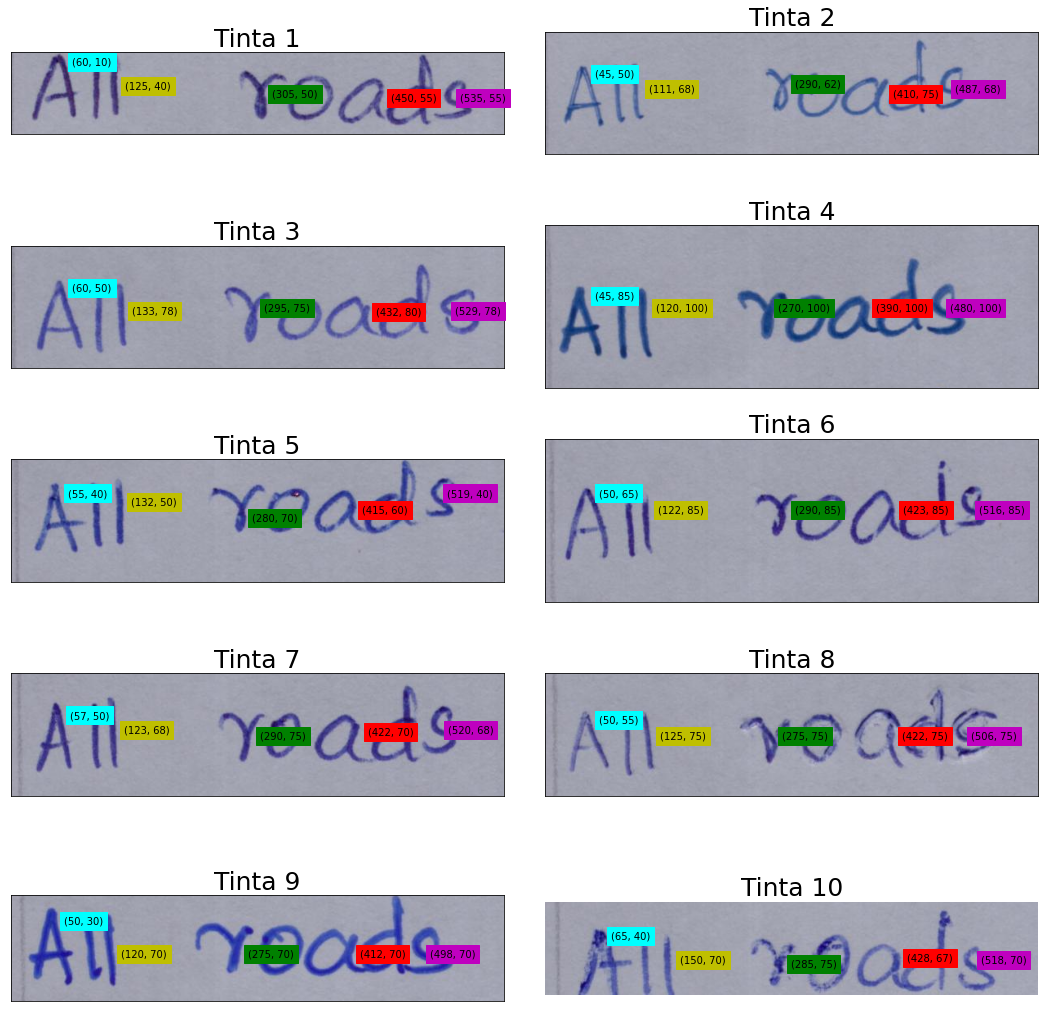

In [86]:
fig, axs = plt.subplots(5, 2, figsize=(15,15))
fig.tight_layout()

pts_ke = [pts,pts_2,pts_3,pts_4,pts_5]
jpg_imgs_plot = rgbs.copy()
colors = [(0.0, 1.0, 1.0), (0.0, 0.5, 0.0), (1.0, 0.0, 0.0), (0.75, 0, 0.75), (0.75, 0.75, 0)]
color255 = [(0,255,255),  (0,255,0), (255,0,0), (255,0,255), (255, 255, 0),]
label = ['Titik 1','Titik 2','Titik 3','Titik 4','Titik 5']

for i, ax in enumerate(axs.ravel()):
    ax.set_title('Tinta ' + str(i+1), fontsize=25)
    
    for titik in range(5):
        cv2.circle(jpg_imgs_plot[i].copy(), pts_ke[titik][i], 2, color255[titik], 2)
        ax.text(pts_ke[titik][i][0]+15,pts_ke[titik][i][1]+5, str(pts_ke[titik][i]), backgroundcolor=colors[titik])

    ax.imshow(jpg_imgs_plot[i])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.grid(b=None)
plt.axis('off')

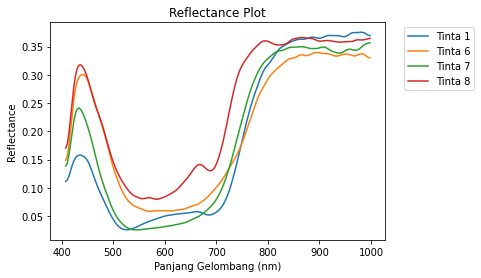

In [87]:
for i in range(10):
    if(i==0 or i==5 or i==6 or i==7):
        plt.plot(wvl, imgs[i][pts[i][1],pts[i][0]], label='Tinta {}'.format(i+1))

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
plt.show()

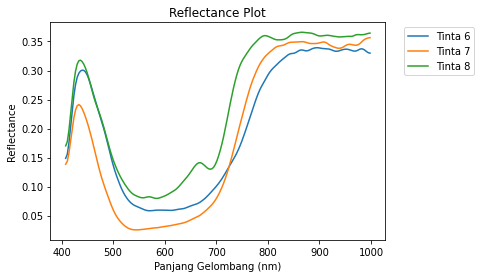

In [88]:
for i in range(10):
    if(i==5 or i==6 or i==7):
        plt.plot(wvl, imgs[i][pts[i][1],pts[i][0]], label='Tinta {}'.format(i+1))

plt.rcParams["figure.figsize"] = (24,14)
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
plt.show()

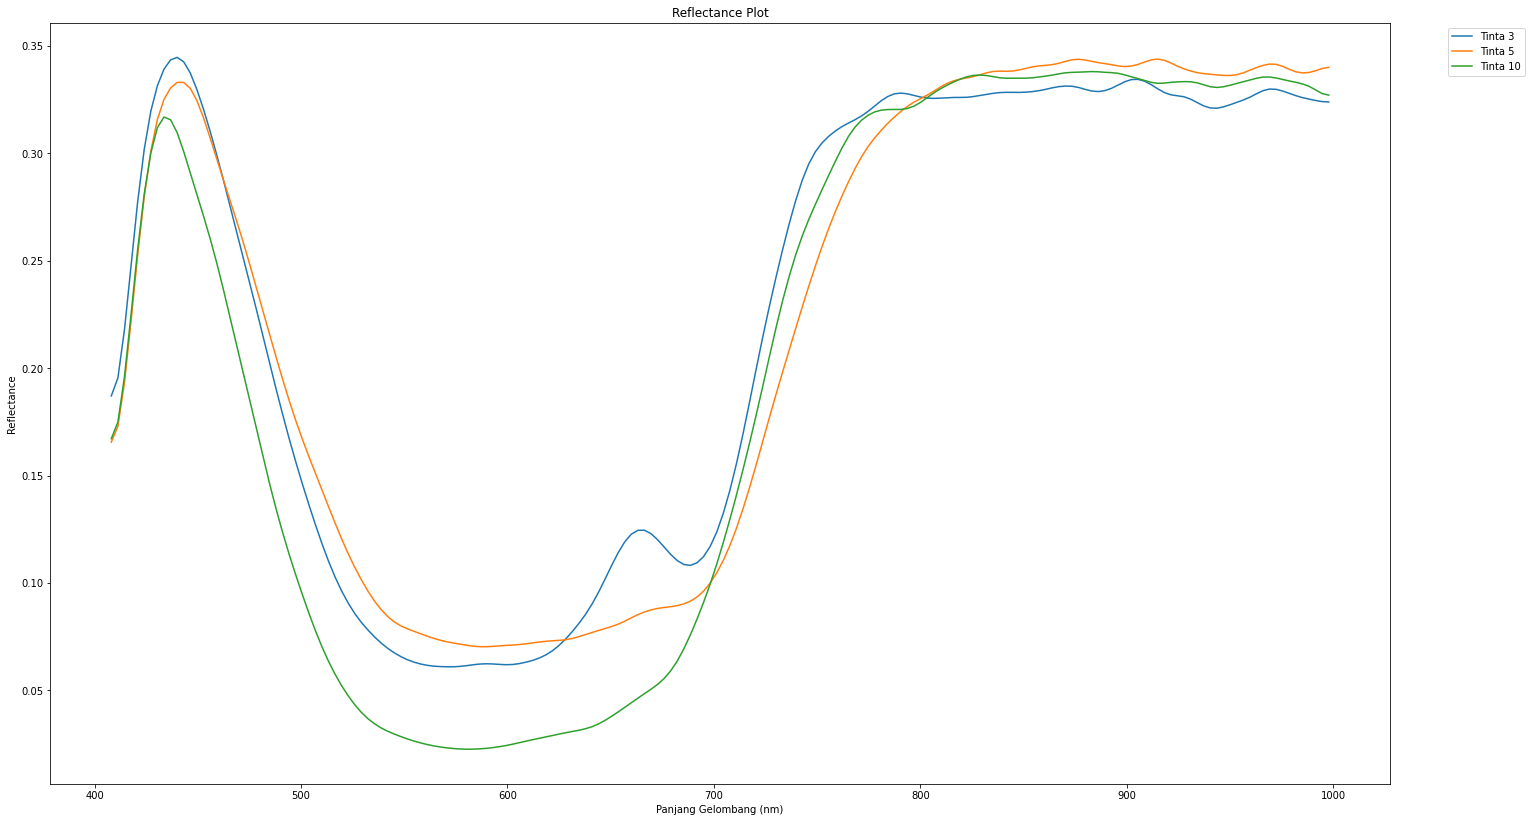

In [100]:
for i in range(10):
    if(i==2 or i==4 or i==9):
        plt.plot(wvl, imgs[i][pts[i][1],pts[i][0]], label='Tinta {}'.format(i+1))

plt.rcParams["figure.figsize"] = (24,14)
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.title('Reflectance Plot')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Reflectance')
plt.show()

# Eksperimen_Pendahuluan

50 titik sampel (5 titik dari tiap tinta)

In [379]:
# populate df 50 titik

x50_arr = []
y50_arr = []
val50_arr = []
label50_arr = []

for pts_ke in range(5):
    for tinta_ke in range(10):
        x50_arr.append(ptss[pts_ke][tinta_ke][1])
        y50_arr.append(ptss[pts_ke][tinta_ke][0])
        label50_arr.append(tinta_ke+1)
        val50_arr.append(imgs[tinta_ke][ptss[pts_ke][tinta_ke][1],ptss[pts_ke][tinta_ke][0]])
        
df_50titik = pd.DataFrame(data = val50_arr)
df_50titik.columns+=1
df_50titik.insert(0,'x',x50_arr)
df_50titik.insert(1,'y',y50_arr)
df_50titik.insert(2, 'label', label50_arr)

In [380]:
df_50titik.head()

x   y  label         1         2         3         4         5         6  \
0  10  60      1  0.111218  0.113748  0.120623  0.130155  0.139940  0.147854   
1  50  45      2  0.167969  0.172358  0.183927  0.198632  0.212129  0.222039   
2  50  60      3  0.187039  0.195461  0.217917  0.247690  0.277322  0.301763   
3  85  45      4  0.145945  0.149344  0.158545  0.171028  0.183854  0.194441   
4  40  55      5  0.165547  0.172936  0.193289  0.221848  0.252449  0.279702   

          7  ...       177       178       179       180       181       182  \
0  0.153149  ...  0.374661  0.374618  0.374843  0.375201  0.375285  0.374750   
1  0.228449  ...  0.398577  0.398598  0.397765  0.396596  0.395526  0.395249   
2  0.319522  ...  0.329863  0.329723  0.328926  0.327880  0.326783  0.325859   
3  0.201545  ...  0.354566  0.354765  0.355444  0.355970  0.355638  0.354364   
4  0.300931  ...  0.341479  0.341373  0.340411  0.339027  0.337872  0.337365   

        183       184       185       186  
0  0.373394  0.371460  0.369896  0.369384  
1  0.395968  0.397194  0.398407  0.398948  
2  0.325178  0.324532  0.324018  0.323851  
3  0.352361  0.349949  0.347944  0.347157  
4  0.337566  0.338359  0.339422  0.339945  

[5 rows x 189 columns]

## a.Wavelength_400-800nm
batasan: yg digunakan band 1-122

In [381]:
complete_dfe_sebagian = reduce_to_2d(df_50titik.iloc[:,:125])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.180503
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.210941
[t-SNE] KL divergence after 1000 iterations: 0.554011
Time t-SNE 27.718961715698242
Explained variation per principal component: [0.75673222 0.14542932]
Cumulative variance explained by 2 principal components: 90.22%
Time PCA 0.032823801040649414


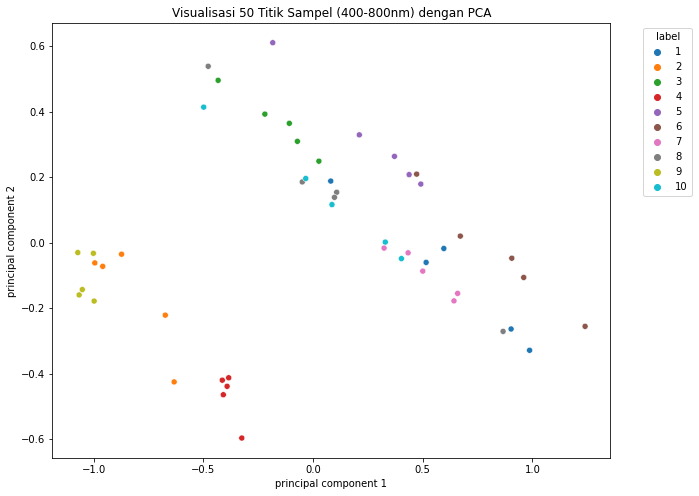

In [384]:
# visualisasi 50 data points 400-800nm (PCA)

plot_dots(complete_dfe_sebagian, opacity=1, size=(10,8), target="label", mode="pca", title="Visualisasi 50 Titik Sampel (400-800nm) dengan PCA")

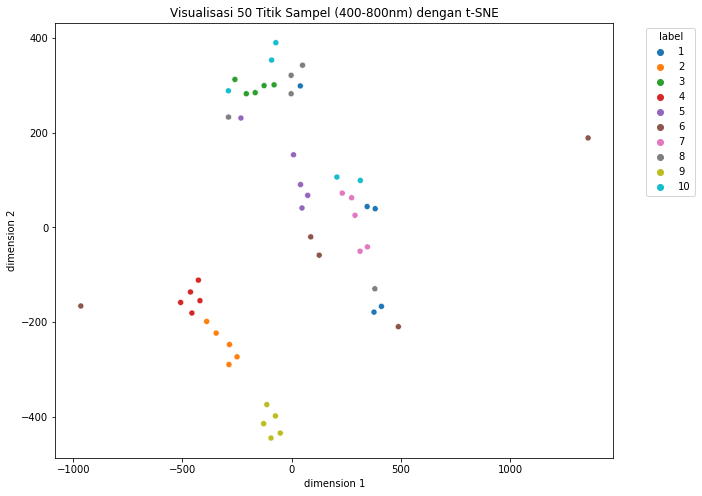

In [385]:
# visualisasi 50 data points 400-800nm (t-SNE)

plot_dots(complete_dfe_sebagian, opacity=1, size=(10,8), target="label", mode="tsne", title="Visualisasi 50 Titik Sampel (400-800nm) dengan t-SNE")

### a.1. No Dimensionality Reduction

In [386]:
def eksperimen_nodim(complete_df, k=10, rand=0):
    complete_df = complete_df.copy()
    
    t0 = time()
    
    df_with_cluster = kmeans(complete_df.drop([i for i in complete_df.columns if isinstance(i, str)], axis=1), k=k, rand=rand)

    complete_df['cluster'] = df_with_cluster['cluster']

    print("Time " + str(time() - t0))
       
    return complete_df

In [387]:
dfe_nodim_sebagian = eksperimen_nodim(complete_dfe_sebagian, k=10, rand=0)

Time 0.0506138801574707


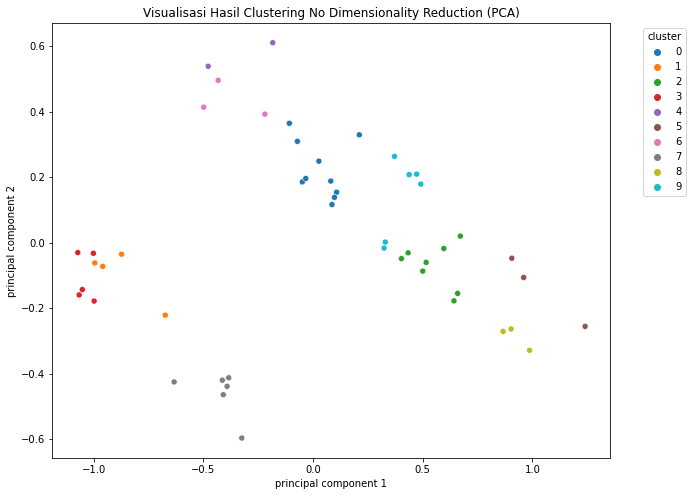

In [391]:
# visualisasi hasil clustering eksperimen pendahuluan no dimensionality reduction 400-800nm (PCA)

plot_dots(dfe_nodim_sebagian, opacity=1, size=(10,8), target="cluster", mode="pca", title="Visualisasi Hasil Clustering No Dimensionality Reduction (PCA)")

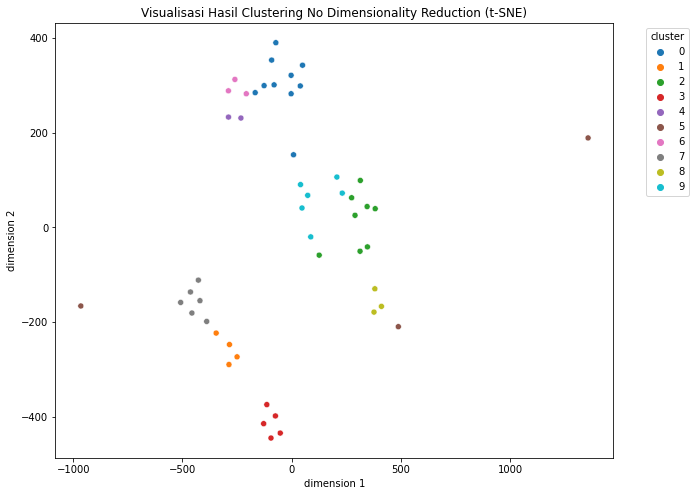

In [392]:
# visualisasi hasil clustering eksperimen pendahuluan no dimensionality reduction 400-800nm (t-SNE)

plot_dots(dfe_nodim_sebagian, opacity=1, size=(10,8), target="cluster", mode="tsne", title="Visualisasi Hasil Clustering No Dimensionality Reduction (t-SNE)")

### a.2. PCA

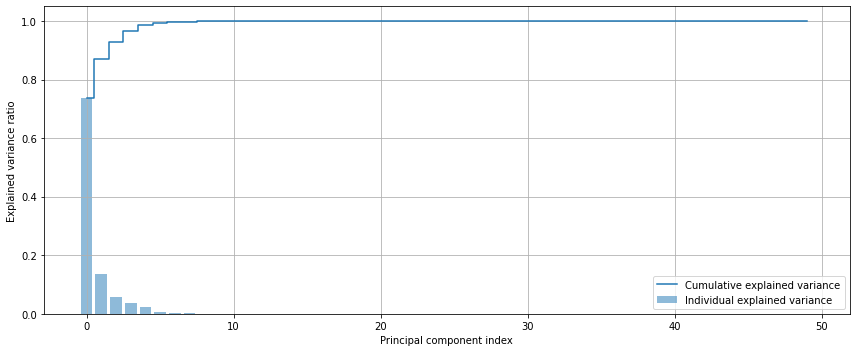

In [393]:
# cek explained variance ratio
# https://vitalflux.com/pca-explained-variance-concept-python-example/

pca = PCA()
X_train_pca = pca.fit_transform(df_50titik.iloc[:,3:])
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.rcParams["figure.figsize"] = (12, 5)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

In [394]:
print("Cumulative explained variace")
print(cum_sum_eigenvalues)
print("")
print("Individual explained variace")
print(exp_var_pca)

Cumulative explained variace
[0.73659153 0.87150751 0.92767373 0.96496819 0.98672471 0.99433301
 0.99697549 0.9982069  0.99867991 0.99891144 0.99910459 0.9992656
 0.99937699 0.99947005 0.99955244 0.99960869 0.99966139 0.99970967
 0.99975166 0.99979021 0.99982127 0.99984855 0.9998734  0.99989303
 0.99991108 0.99992502 0.99993727 0.99994851 0.99995875 0.99996545
 0.99997154 0.99997648 0.9999809  0.99998477 0.9999881  0.99999051
 0.99999268 0.99999413 0.99999554 0.99999665 0.99999753 0.99999829
 0.99999888 0.99999933 0.99999957 0.99999975 0.99999987 0.99999995
 1.         1.        ]

Individual explained variace
[7.36591531e-01 1.34915975e-01 5.61662253e-02 3.72944545e-02
 2.17565197e-02 7.60830181e-03 2.64248439e-03 1.23140975e-03
 4.73004464e-04 2.31536877e-04 1.93145391e-04 1.61013538e-04
 1.11385650e-04 9.30590457e-05 8.23895136e-05 5.62505019e-05
 5.26983665e-05 4.82850668e-05 4.19902877e-05 3.85487634e-05
 3.10644889e-05 2.72781680e-05 2.48463340e-05 1.96268554e-05
 1.80551949e-05 

In [395]:
def eksperimen_pca(complete_df, k=10, rand=0):
    complete_df = complete_df.copy()
    
    t0 = time()
    
    df_with_cluster = kmeans(
        complete_df.drop(complete_df.columns.difference(['principal component 1','principal component 2']), 1),
        k=k, rand=rand)

    complete_df['cluster'] = df_with_cluster['cluster']

    print("Time " + str(time() - t0))
       
    return complete_df

In [396]:
dfe_pca_sebagian = eksperimen_pca(complete_dfe_sebagian, k=10)

Time 0.04360842704772949


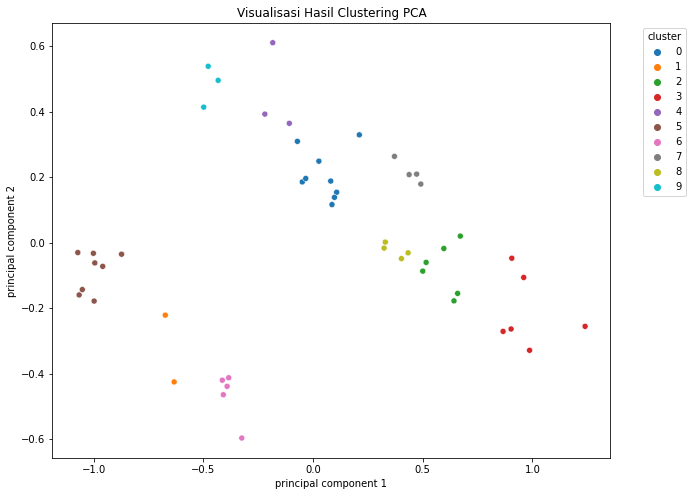

In [397]:
# visualisasi hasil clustering eksperimen pendahuluan PCA 400-800nm

plot_dots(dfe_pca_sebagian, opacity=1, size=(10,8), target="cluster", mode="pca", title="Visualisasi Hasil Clustering PCA")

In [398]:
def counter_cluster(df):
    fig, axs = plt.subplots(5, 2)
    fig.tight_layout()

    for i, ax in enumerate(axs.ravel()):
        ax.set_title('Cluster ' + str(i))

        a_dictionary = collections.Counter(df[df.cluster==i]['label'])
        print(a_dictionary)
        ax.bar(a_dictionary.keys(), a_dictionary.values())
        ax.set_xticks([i for i in range(10)])

Counter({8: 3, 3: 2, 10: 2, 5: 1, 1: 1})
Counter({2: 2})
Counter({7: 3, 1: 2, 6: 1})
Counter({6: 3, 1: 2, 8: 1})
Counter({3: 2, 5: 1})
Counter({9: 5, 2: 3})
Counter({4: 5})
Counter({5: 3, 6: 1})
Counter({10: 2, 7: 2})
Counter({8: 1, 3: 1, 10: 1})


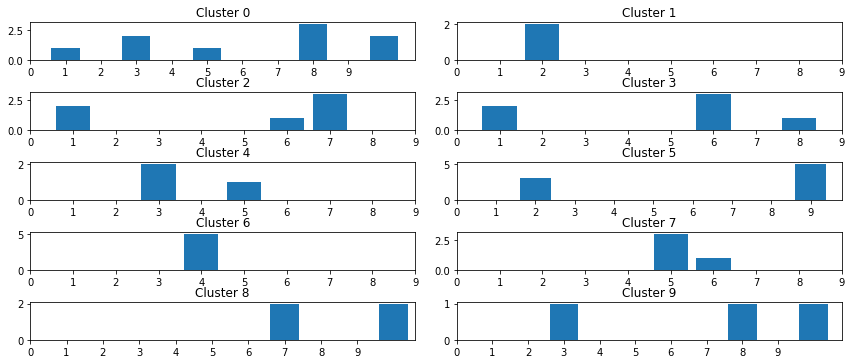

In [399]:
counter_cluster(dfe_pca_sebagian)

### a.3. t-SNE

In [400]:
def eksperimen_tsne(complete_df, k=10, rand=0):
    complete_df = complete_df.copy()
    
    t0 = time()
    
    df_with_cluster = kmeans(
        complete_df.drop(complete_df.columns.difference(['dimension 1','dimension 2']), 1),
        k=k, rand=rand)

    complete_df['cluster'] = df_with_cluster['cluster']

    print("Time " + str(time() - t0))
       
    return complete_df

In [401]:
dfe_tsne_sebagian = eksperimen_tsne(complete_dfe_sebagian, k=10)

Time 0.05115532875061035


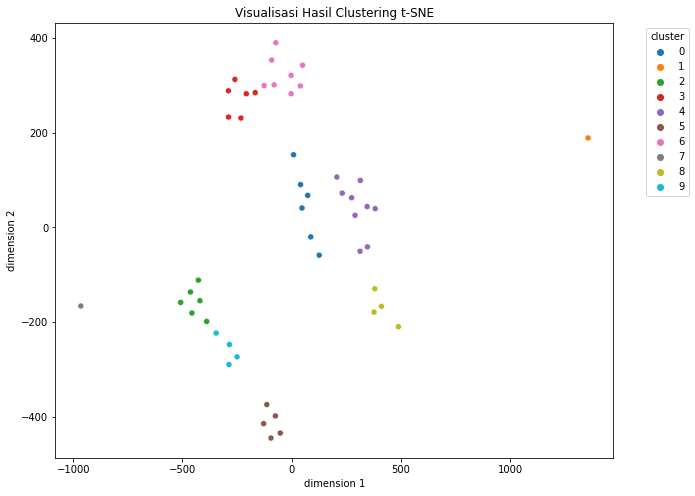

In [403]:
# visualisasi hasil clustering eksperimen pendahuluan t-SNE 400-800nm

plot_dots(dfe_tsne_sebagian, opacity=1, size=(10,8), target="cluster", mode="tsne", title="Visualisasi Hasil Clustering t-SNE")

In [946]:
# tuning

Init Random, perplexity=5 in 26 sec
Init Random, perplexity=30 in 26 sec
Init Random, perplexity=50 in 26 sec
Init Random, perplexity=100 in 26 sec
Init PCA, perplexity=5 in 26 sec
Init PCA, perplexity=30 in 26 sec
Init PCA, perplexity=50 in 24 sec
Init PCA, perplexity=100 in 24 sec


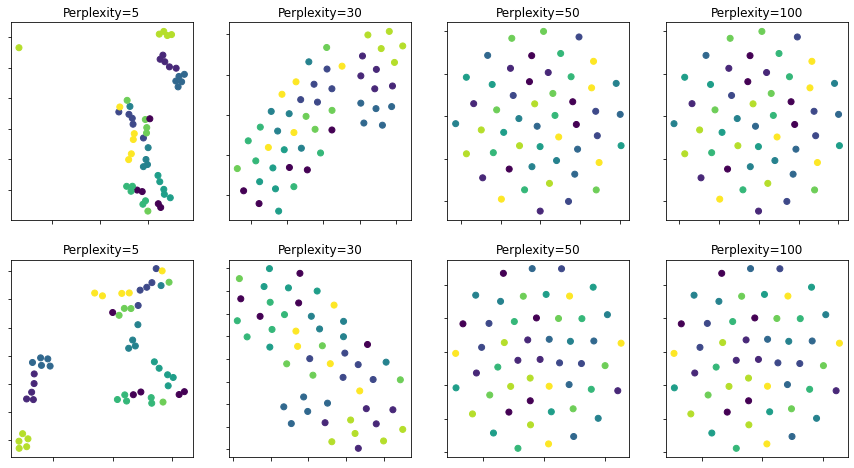

In [404]:
# code from sklearn documentation
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets

n_samples = 50
n_components = 2
(fig, subplots) = plt.subplots(2, 4, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = df_50titik.iloc[:,3:], df_50titik.iloc[:,2]

ax = subplots[0][0]
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i]

    t0 = time()
    tsne_model = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne_model.fit_transform(X)
    t1 = time()
    print("Init Random, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# init pca

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i]

    t0 = time()
    tsne_model = manifold.TSNE(n_components=n_components, init='pca',
                         random_state=0, perplexity=perplexity)
    Y = tsne_model.fit_transform(X)
    t1 = time()
    print("Init PCA, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

Init Random, iter=1000 in 26 sec
Init Random, iter=2000 in 51 sec
Init Random, iter=2999 in 77 sec
Init PCA, iter=1000 in 26 sec
Init PCA, iter=2000 in 52 sec
Init PCA, iter=3000 in 26 sec


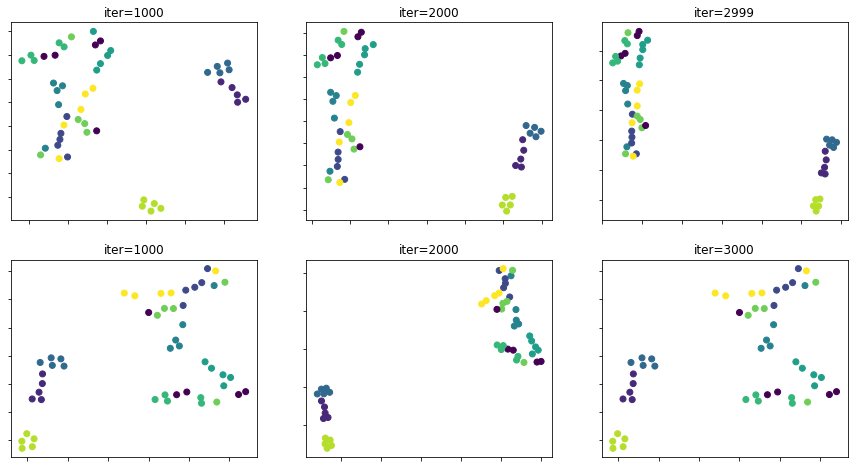

In [405]:
n_samples = 50
n_components = 2
(fig, subplots) = plt.subplots(2, 3, figsize=(15, 8))
perplexities = [5, 30, 50, 100]
stepsizes = [1000, 2000, 3000]

X, y = df_50titik.iloc[:,3:], df_50titik.iloc[:,2]


for i, stepsize in enumerate(stepsizes):
    ax = subplots[0][i]

    t0 = time()
    
    tsne_model = manifold.TSNE(n_components=n_components, init='random',
                         random_state=42, perplexity=5, n_iter=stepsize)
        
    Y = tsne_model.fit_transform(X)
    t1 = time()
    
    if (i==2):
        print("Init Random, iter=%d in %.2g sec" % (tsne_model.n_iter_, t1 - t0))
        ax.set_title("iter=%d" % tsne_model.n_iter_)
    else:
        print("Init Random, iter=%d in %.2g sec" % (stepsize, t1 - t0))
        ax.set_title("iter=%d" % stepsize)    
    
    ax.scatter(Y[:, 0], Y[:, 1], c=y)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# init pca

for i, stepsize in enumerate(stepsizes):
    ax = subplots[1][i]

    t0 = time()
    
    if (i==2):
        tsne_model = manifold.TSNE(n_components=n_components, init='pca',
                         random_state=42, perplexity=5)
    else:
        tsne_model = manifold.TSNE(n_components=n_components, init='pca',
                         random_state=42, perplexity=5, n_iter=stepsize)
    Y = tsne_model.fit_transform(X)
    t1 = time()
    

    print("Init PCA, iter=%d in %.2g sec" % (stepsize, t1 - t0))
    ax.set_title("iter=%d" % stepsize)   
        
    ax.scatter(Y[:, 0], Y[:, 1], c=y)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

## b.Wavelength_400-1000nm

In [411]:
complete_dfe_penuh = reduce_to_2d(df_50titik)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.204254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.884315
[t-SNE] KL divergence after 1000 iterations: 0.259305
Time t-SNE 25.81663155555725
Explained variation per principal component: [0.73659153 0.13491598]
Cumulative variance explained by 2 principal components: 87.15%
Time PCA 0.020532608032226562


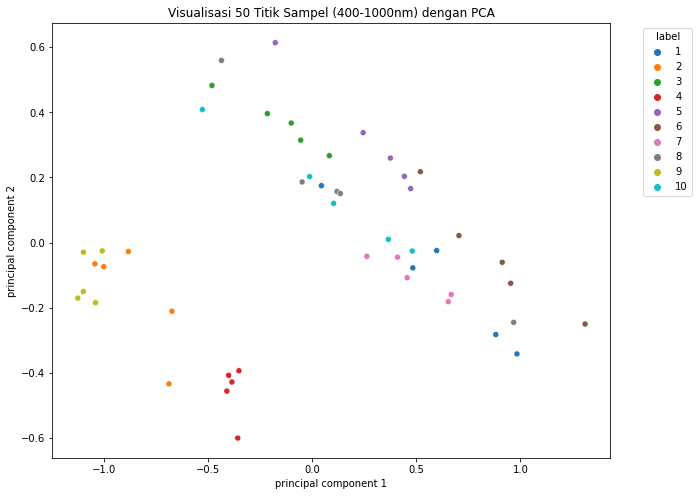

In [412]:
# visualisasi 50 data points 400-1000nm (PCA)

plot_dots(complete_dfe_penuh, opacity=1, size=(10,8), target="label", mode="pca", title="Visualisasi 50 Titik Sampel (400-1000nm) dengan PCA")

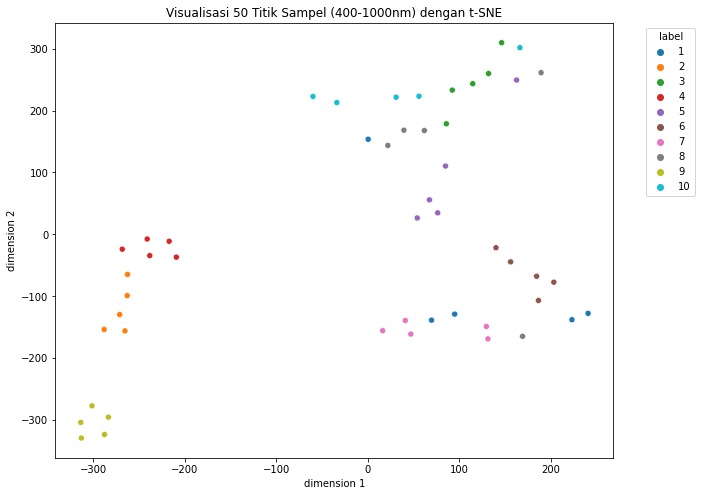

In [413]:
# visualisasi 50 data points 400-1000nm (t-SNE)

plot_dots(complete_dfe_penuh, opacity=1, size=(10,8), target="label", mode="tsne", title="Visualisasi 50 Titik Sampel (400-1000nm) dengan t-SNE")

### b.1. No Dimensionality Reduction

In [414]:
dfe_nodim_penuh = eksperimen_nodim(complete_dfe_penuh, k=10, rand=0)

Time 0.05613899230957031


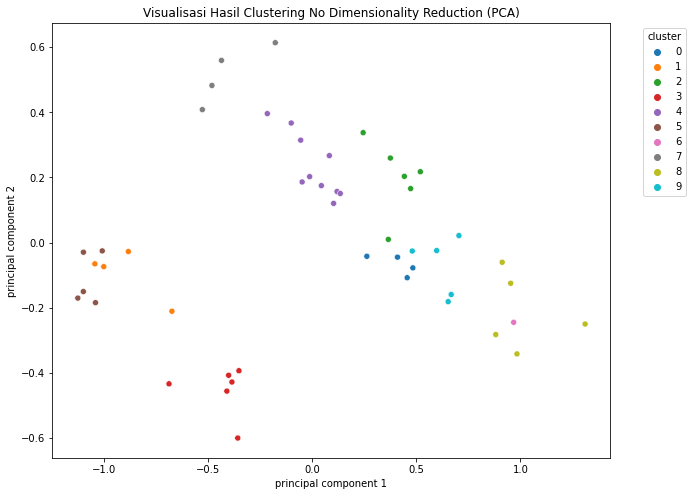

In [415]:
# visualisasi hasil clustering eksperimen pendahuluan no dimensionality reduction 400-1000nm (PCA)

plot_dots(dfe_nodim_penuh, opacity=1, size=(10,8), target="cluster", mode="pca", title="Visualisasi Hasil Clustering No Dimensionality Reduction (PCA)")

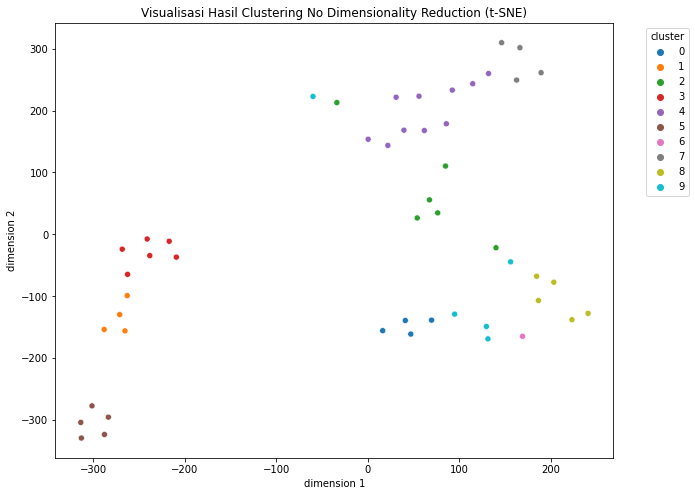

In [416]:
# visualisasi hasil clustering eksperimen pendahuluan no dimensionality reduction 400-1000nm (t-SNE)

plot_dots(dfe_nodim_penuh, opacity=1, size=(10,8), target="cluster", mode="tsne", title="Visualisasi Hasil Clustering No Dimensionality Reduction (t-SNE)")

Counter({7: 3, 1: 1})
Counter({2: 4})
Counter({5: 4, 6: 1, 10: 1})
Counter({4: 5, 2: 1})
Counter({3: 4, 8: 3, 10: 2, 1: 1})
Counter({9: 5})
Counter({8: 1})
Counter({5: 1, 8: 1, 3: 1, 10: 1})
Counter({6: 3, 1: 2})
Counter({7: 2, 10: 1, 6: 1, 1: 1})


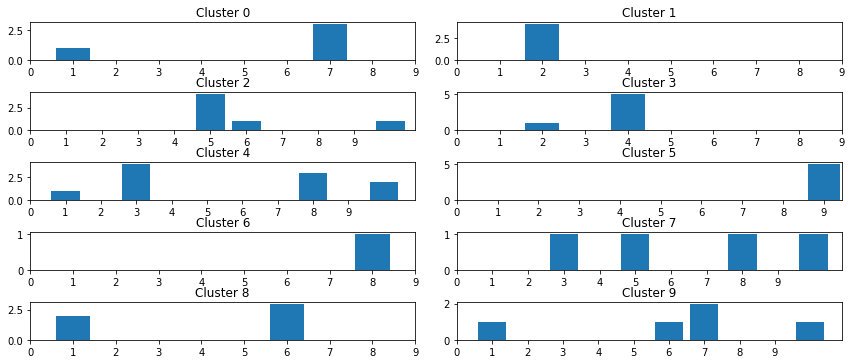

In [417]:
counter_cluster(dfe_nodim_penuh)

### b.2. PCA

In [418]:
dfe_pca_penuh = eksperimen_pca(complete_dfe_penuh, k=10)

Time 0.046459197998046875


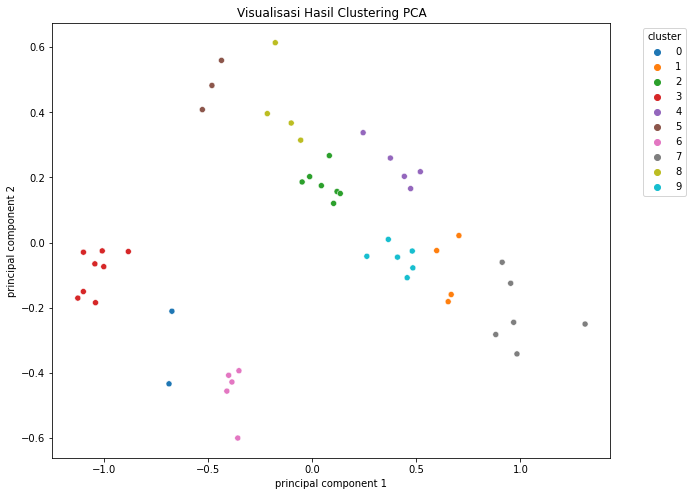

In [419]:
# visualisasi hasil clustering eksperimen pendahuluan PCA 400-1000nm

plot_dots(dfe_pca_penuh, opacity=1, size=(10,8), target="cluster", mode="pca", title="Visualisasi Hasil Clustering PCA")

Counter({2: 2})
Counter({7: 2, 6: 1, 1: 1})
Counter({8: 3, 10: 2, 3: 1, 1: 1})
Counter({9: 5, 2: 3})
Counter({5: 4, 6: 1})
Counter({8: 1, 3: 1, 10: 1})
Counter({4: 5})
Counter({6: 3, 1: 2, 8: 1})
Counter({3: 3, 5: 1})
Counter({7: 3, 10: 2, 1: 1})


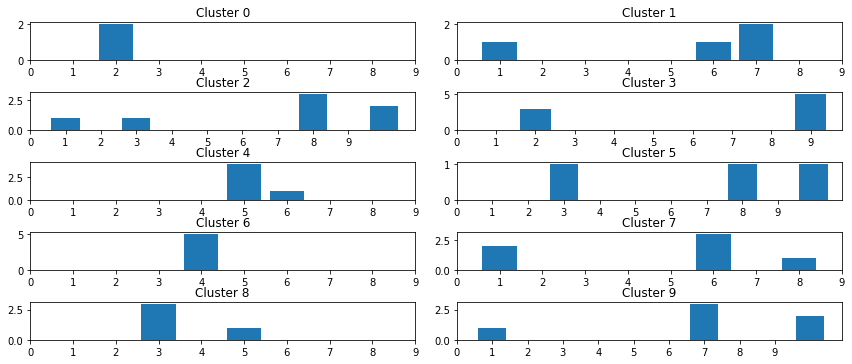

In [420]:
counter_cluster(dfe_pca_penuh)

### a.3. t-SNE

In [421]:
dfe_tsne_penuh = eksperimen_tsne(complete_dfe_penuh, k=10)

Time 0.05570840835571289


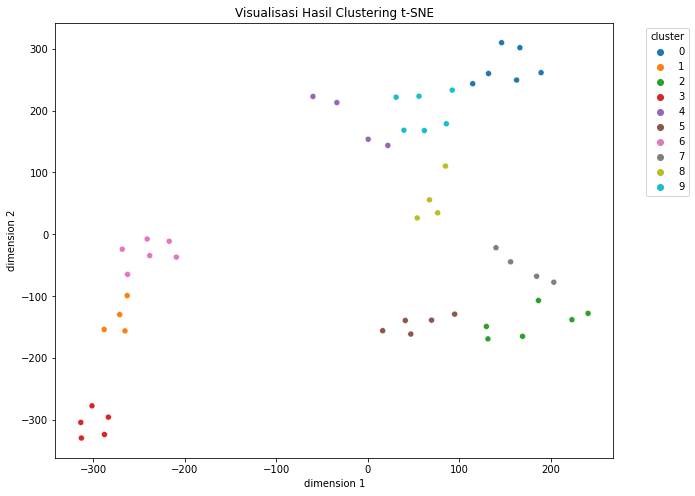

In [422]:
# visualisasi hasil clustering eksperimen pendahuluan t-SNE 400-1000nm

plot_dots(dfe_tsne_penuh, opacity=1, size=(10,8), target="cluster", mode="tsne", title="Visualisasi Hasil Clustering t-SNE")

# Eksperimen_Utama

## a.3_Tinta

In [423]:
# exploratory for mask

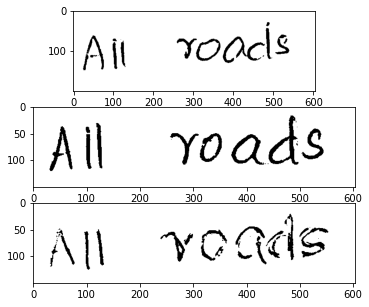

In [424]:
fig, axs = plt.subplots(3)
m6 = sauvola_masking(rgbs[5])
m7 = sauvola_masking(rgbs[6])
m8 = sauvola_masking(rgbs[7])
axs[0].imshow(m6, cmap='gray')
axs[1].imshow(m7, cmap='gray')
axs[2].imshow(m8, cmap='gray')

tinta 6 1966 2677 1728
tinta 7 2137 2642 2120
tinta 8 1231 2307 1871


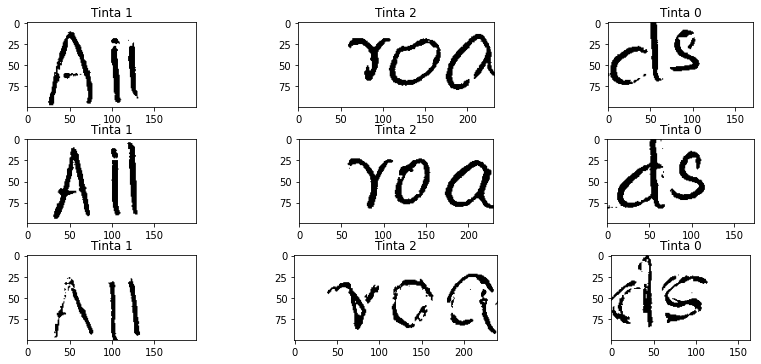

In [425]:
ms = [ m6[50:150,:200], m6[50:150,200:432], m6[50:150,432:],
         m7[25:125,:200], m7[25:125,200:430], m7[25:125,430:],
          m8[22:122,:200], m8[22:122,200:440], m8[22:122,440:],
     ]

print("tinta 6 {} {} {}".format(np.count_nonzero(ms[0] == 0), np.count_nonzero(ms[1] == 0), np.count_nonzero(ms[2] == 0)))
print("tinta 7 {} {} {}".format(np.count_nonzero(ms[3] == 0), np.count_nonzero(ms[4] == 0), np.count_nonzero(ms[5] == 0)))
print("tinta 8 {} {} {}".format(np.count_nonzero(ms[6] == 0), np.count_nonzero(ms[7] == 0), np.count_nonzero(ms[8] == 0)))

fig, axs = plt.subplots(3, 3)
fig.tight_layout()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(ms[i],cmap='gray')
    ax.set_title('Tinta ' + str((i+1)%3))
    ax.axis('on')

In [426]:
from scipy import ndimage

eroded = ndimage.binary_dilation(ms[4].copy(), structure=np.ones((2,3))).astype(ms[4].dtype)
# plt.imshow(eroded,cmap='gray')
print(np.count_nonzero(eroded == 0))

1817


In [427]:
def multi_img_to_df(list_image, list_mask, list_label):    
    df_results = []
    
    for i in range(len(list_image)):
        shape = list_image[i].shape
        image = list_image[i]
        mask = list_mask[i]
        label = list_label[i]
        
        x_arr = []
        y_arr = []
        val_arr = []
        label_arr = []

        # populate x, y
        for x in range(shape[0]):
            for y in range(shape[1]):
#                 print(x, y, image.shape, mask.shape)
                if (mask[x][y]==False):
                    x_arr.append(x)
                    y_arr.append(y)
                    val_arr.append(image[x][y])
                    label_arr.append(label)

        df = pd.DataFrame(data = val_arr)
        df.columns+=1
        df.insert(0,'x',x_arr)
        df.insert(1,'y',y_arr)
        df.insert(2, 'label', label_arr)
        
        df_results.append(df)
        
    img = np.concatenate((list_image[0],list_image[1],list_image[2]),axis=1)
    mask = np.concatenate((list_mask[0],list_mask[1],list_mask[2]), axis=1)
    
    return df_results, img, mask

In [428]:
%%time

dfs_3tinta, img_3tinta, mask_3tinta = multi_img_to_df([imgs[5][50:150,20:140], imgs[6][25:125,200:430], imgs[7][22:122,440:560]],
                             [m6[50:150,20:140], eroded, m8[22:122,440:560]], [6,7,8])

CPU times: user 338 ms, sys: 36.2 ms, total: 375 ms
Wall time: 369 ms


In [429]:
#merge 3 df
df_3tinta = dfs_3tinta[0].copy()

for i in range(1,3):
    df_3tinta = df_3tinta.append(dfs_3tinta[i])

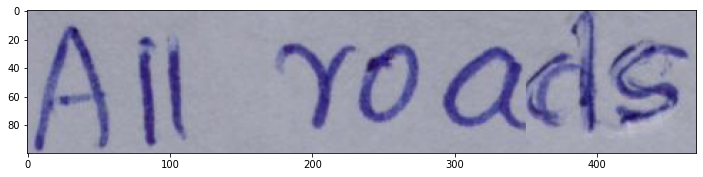

In [430]:
rgb_3tinta = np.concatenate((rgbs[5][50:150,20:140], rgbs[6][25:125,200:430], rgbs[7][22:122,440:560]), axis=1)
plt.imshow(rgb_3tinta)

In [431]:
# visualisasi data points

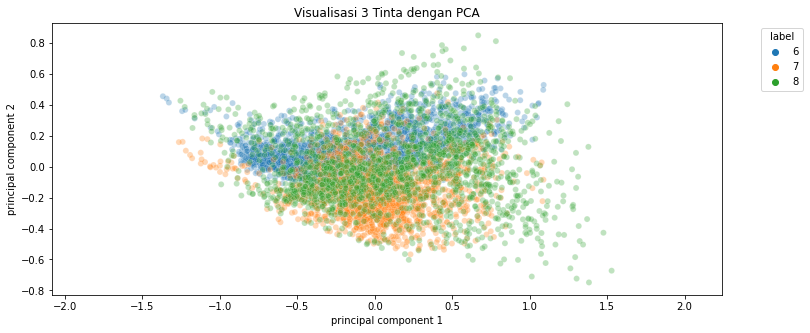

In [508]:
# visualisasi eksperimen utama 10 tinta (PCA)

plot_dots(complete_dfe3, opacity=0.3, axis="equal", target="label", mode="pca", title="Visualisasi 3 Tinta dengan PCA")

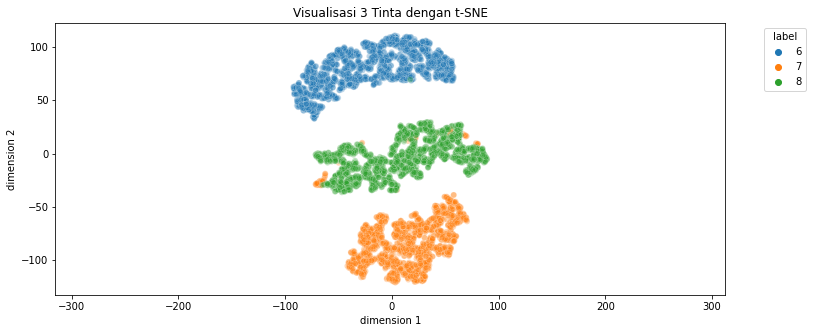

In [512]:
# visualisasi eksperimen utama 10 tinta (t-SNE)

plot_dots(complete_dfe3, opacity=0.3, axis="equal", target="label", mode="tsne", title="Visualisasi 3 Tinta dengan t-SNE")

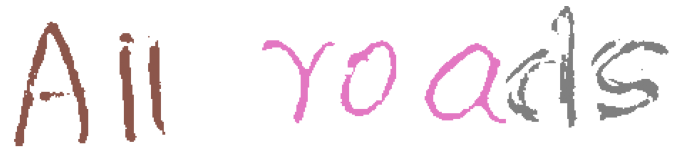

In [550]:
# ground truth on image (colors may vary in experiments)

img_dfe3_gt = visualize_on_image(complete_dfe3, mask_3tinta, labels=[6,7,8], tipe="3 tinta", target="label")

### a.1. no dimensionality reduction

In [513]:
dfe3_nodim = eksperimen_nodim(complete_dfe3, k=3)

Time 1.654923915863037


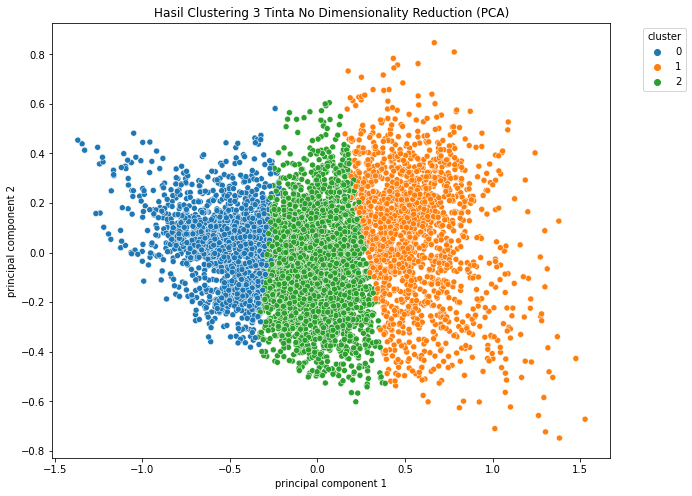

In [517]:
# visualisasi hasil clustering eksperimen utama 10 tinta (PCA)

plot_dots(dfe3_nodim, opacity=1, size=(10,8), target="cluster", mode="pca", title="Hasil Clustering 3 Tinta No Dimensionality Reduction (PCA)")

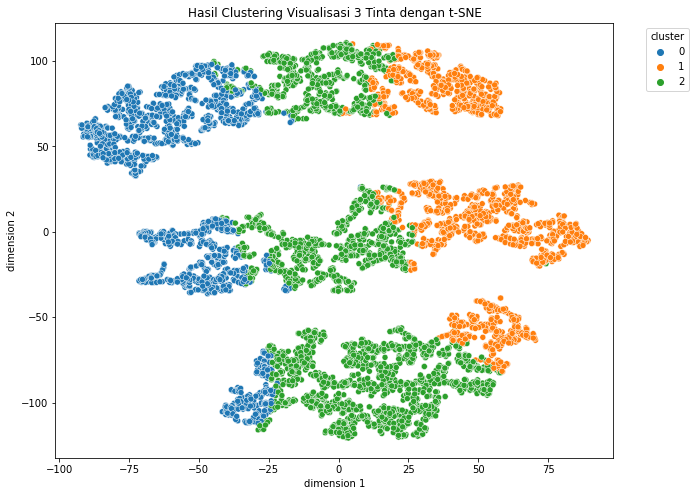

In [515]:
# visualisasi hasil clustering eksperimen utama 10 tinta (t-SNE)

plot_dots(dfe3_nodim, opacity=1, size=(10,8), target="cluster", mode="tsne", title="Hasil Clustering Visualisasi 3 Tinta dengan t-SNE")

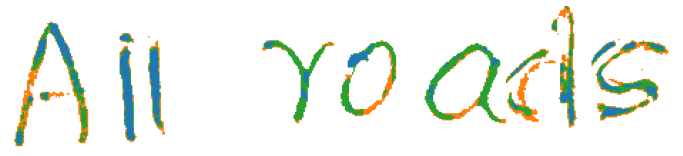

In [529]:
img_dfe3_nodim = visualize_on_image(dfe3_nodim, mask_3tinta, labels=[6,7,8], tipe="3 tinta", target="cluster")

### a.2. PCA

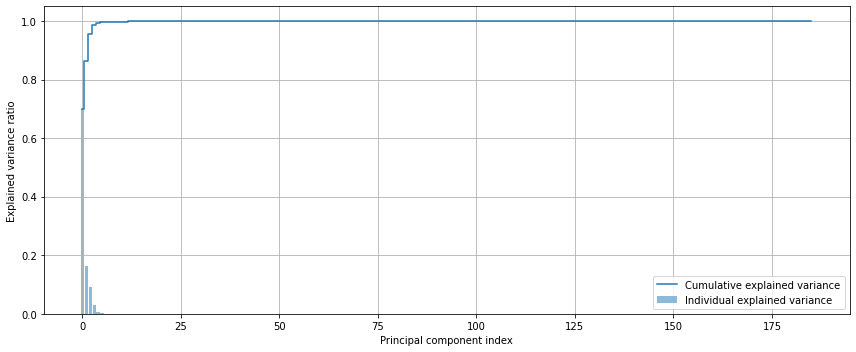

In [531]:
# cek explained variance ratio
# https://vitalflux.com/pca-explained-variance-concept-python-example/

pca = PCA()
X3tinta_train_pca = pca.fit_transform(df_3tinta.iloc[:,3:])
exp_var_pca_3tinta = pca.explained_variance_ratio_
cum_sum_eigenvalues_3tinta = np.cumsum(exp_var_pca_3tinta)

plt.rcParams["figure.figsize"] = (12, 5)

plt.bar(range(0,len(exp_var_pca_3tinta)), exp_var_pca_3tinta, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_3tinta)), cum_sum_eigenvalues_3tinta, where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

In [532]:
print("Cumulative explained variace")
print(cum_sum_eigenvalues_3tinta)
print("")
print("Individual explained variace")
print(exp_var_pca_3tinta)

Cumulative explained variace
[0.70027951 0.86496074 0.95590429 0.98702157 0.99262322 0.99541202
 0.9963957  0.99690531 0.99734226 0.99771042 0.99802487 0.99828957
 0.99850802 0.99868293 0.99882991 0.99895845 0.99906825 0.99916855
 0.99926025 0.99933886 0.99940753 0.99947208 0.99952723 0.99957575
 0.99962123 0.99966129 0.99969819 0.99972993 0.99975846 0.99978232
 0.99980566 0.9998267  0.99984559 0.99986159 0.99987649 0.99989004
 0.99990254 0.99991385 0.99992399 0.99993318 0.99994147 0.99994884
 0.99995535 0.99996133 0.99996673 0.99997136 0.99997545 0.99997905
 0.99998219 0.99998491 0.99998736 0.99998936 0.99999107 0.99999261
 0.99999386 0.99999488 0.99999577 0.99999653 0.99999714 0.99999767
 0.99999807 0.99999839 0.99999863 0.99999882 0.99999897 0.99999909
 0.9999992  0.9999993  0.99999938 0.99999944 0.9999995  0.99999956
 0.9999996  0.99999964 0.99999968 0.9999997  0.99999973 0.99999976
 0.99999978 0.9999998  0.99999981 0.99999983 0.99999984 0.99999986
 0.99999987 0.99999988 0.99999989

In [536]:
dfe3_pca = eksperimen_pca(complete_dfe3, k=3)

Time 1.3322949409484863


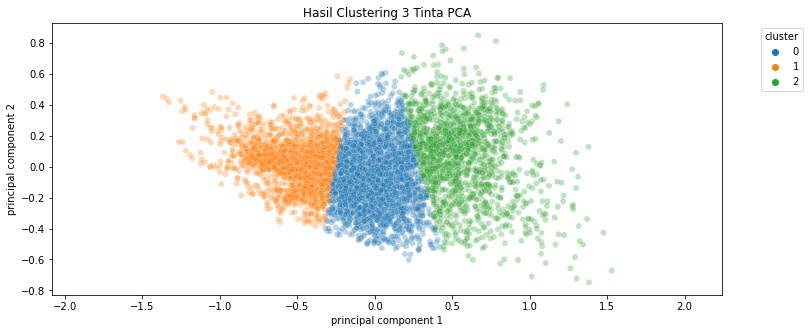

In [539]:
# visualisasi hasil clustering eksperimen utama 10 tinta (PCA)

plot_dots(dfe3_pca, opacity=0.3, axis="equal", target="cluster", mode="pca", title="Hasil Clustering 3 Tinta PCA")

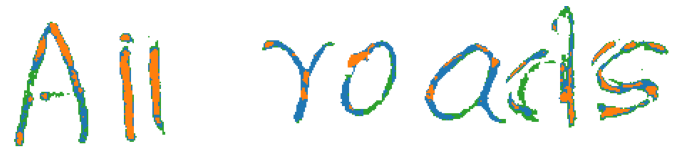

In [599]:
img_dfe3_pca = visualize_on_image(dfe3_pca, mask_3tinta, labels=[6,7,8], tipe="3 tinta", target="cluster")

### a.3. t-SNE

In [546]:
dfe3_tsne = eksperimen_tsne(complete_dfe3, k=3)

Time 0.11608457565307617


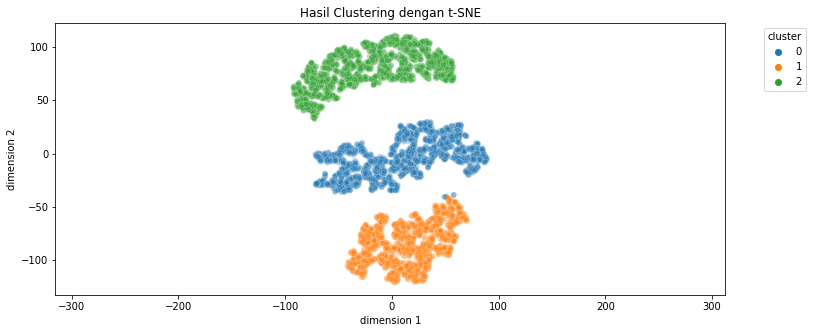

In [547]:
plot_dots(dfe3_tsne, opacity=0.3, axis="equal", mode="tsne", target="cluster", title="Hasil Clustering dengan t-SNE")

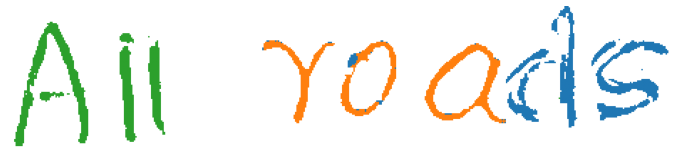

In [598]:
img_dfe3_tsne = visualize_on_image(dfe3_tsne, mask_3tinta, labels=[6,7,8], tipe="3 tinta", target="cluster")

## b.10_Tinta

In [1333]:
%%time

# populate 4000 samples per ink (set random state)

df_10ink_balance = dfs[0].sample(n = 4000).copy()

df_samples = []

for i in range(1,10):
    df_samples.append(dfs[i].sample(n = 4000))
    df_10ink_balance = df_10ink_balance.append(df_samples[i-1])

CPU times: user 0 ns, sys: 28.3 s, total: 28.3 s
Wall time: 28.5 s


In [549]:
# example using import (last session data)

df_10ink_balance = pd.read_excel(open('excels/original_eksperimen_10tinta_result.xls', 'rb'), sheet_name='df_10ink_balance', index_col = 0)
df_10ink_balance

x    y  label         1         2         3         4         5  \
1806   38  296      1  0.147377  0.152246  0.165777  0.184222  0.202779   
4219   61  474      1  0.164710  0.169298  0.181975  0.199443  0.217699   
5381   73  432      1  0.195428  0.204202  0.228215  0.260646  0.293293   
2059   40  432      1  0.168106  0.174957  0.193377  0.218188  0.243820   
3947   59   31      1  0.160077  0.166273  0.182860  0.205764  0.230695   
...   ...  ...    ...       ...       ...       ...       ...       ...   
3736   89  512     10  0.223817  0.231617  0.252972  0.282674  0.313962   
4651  101  343     10  0.216419  0.225879  0.251290  0.285503  0.320416   
321    42   65     10  0.176979  0.184342  0.204182  0.231465  0.260373   
4247   96  432     10  0.210705  0.219448  0.243463  0.276643  0.310978   
4036   94   82     10  0.225638  0.236038  0.264098  0.301997  0.340709   

             6         7  ...       177       178       179       180  \
1806  0.218159  0.229411  ...  0.386927  0.386840  0.386461  0.386329   
4219  0.233740  0.246338  ...  0.410260  0.408930  0.407580  0.406503   
5381  0.320533  0.340279  ...  0.343035  0.344341  0.345470  0.346175   
2059  0.266056  0.283471  ...  0.350661  0.349940  0.349196  0.348625   
3947  0.253645  0.272534  ...  0.382269  0.384146  0.385435  0.386014   
...        ...       ...  ...       ...       ...       ...       ...   
3736  0.341332  0.362446  ...  0.381884  0.381300  0.380998  0.381217   
4651  0.349674  0.370276  ...  0.356892  0.357381  0.358360  0.359432   
321   0.285651  0.304813  ...  0.339833  0.340694  0.341737  0.342548   
4247  0.339996  0.360748  ...  0.376450  0.374960  0.373643  0.372807   
4036  0.373177  0.396149  ...  0.376864  0.376979  0.377126  0.377147   

           181       182       183       184       185       186  
1806  0.386588  0.387219  0.388101  0.388780  0.389177  0.389369  
4219  0.406183  0.406493  0.406988  0.407418  0.407522  0.407476  
5381  0.346498  0.346327  0.345631  0.344778  0.344230  0.344073  
2059  0.348428  0.348598  0.348969  0.349724  0.350716  0.351176  
3947  0.385704  0.384702  0.383253  0.381636  0.380488  0.380163  
...        ...       ...       ...       ...       ...       ...  
3736  0.381604  0.381922  0.382237  0.382519  0.382709  0.382773  
4651  0.359827  0.359274  0.357876  0.356212  0.355081  0.354720  
321   0.343106  0.343407  0.343591  0.344115  0.344858  0.345196  
4247  0.372771  0.373705  0.375050  0.376188  0.376852  0.377018  
4036  0.376800  0.376473  0.376757  0.377478  0.378122  0.378381  

[40000 rows x 189 columns]

In [551]:
df_gt_nodim = df_10ink_balance.copy()
df_gt_nodim['label'] = df_gt_nodim['label'].replace({1:1,
2:6,
3:2,
4:4,
5:5,
6:8,
7:0,
8:7,
9:3,
10:9,
})

In [552]:
def plot_10ink_label(df,shape):
    
    df_adjusted = df.copy().reset_index()

    for i in range(1, 10):
        df_adjusted.loc[df_adjusted.label == i+1, ['x']] += (yends[i-1])
        
    picture = np.full((shape[0], shape[1],3), (1.0, 1.0, 1.0))

    for index, row in df_adjusted.iterrows():
        picture[int(row['x']), int(row['y'])] = sns.color_palette()[int(row['label'])-1]
        
    return picture

(-0.5, 603.5, 1593.5, -0.5)

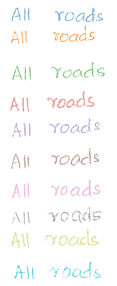

In [553]:
img_dfe10_gt = plot_10ink_label(df_10ink_balance, (1594, 604))
plt.imshow(img_dfe10_gt)
plt.axis('off')

In [554]:
cv2.imwrite('sampel_10tinta.jpg', img_dfe10_gt*255)
sampling_rgb = cv2.cvtColor(cv2.imread('sampel_10tinta.jpg'), cv2.COLOR_BGR2RGB)

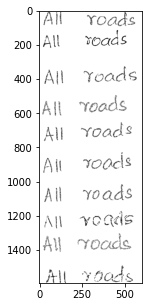

In [555]:
mask_10tinta = sauvola_masking(sampling_rgb)
plt.imshow(mask_10tinta, cmap='gray')

In [559]:
# example using import (last session data)

last_dfe10_tsne = pd.read_excel(open('excels/original_eksperimen_10tinta_result.xls', 'rb'), sheet_name='dfe10_tsne', index_col = 0)
last_dfe10_pca = pd.read_excel(open('excels/original_eksperimen_10tinta_result.xls', 'rb'), sheet_name='dfe10_pca2', index_col = 0)

In [572]:
complete_dfe10 = df_10ink_balance.copy().reset_index()
complete_dfe10['principal component 1'] = last_dfe10_pca['principal component 1']
complete_dfe10['principal component 2'] = last_dfe10_pca['principal component 2']
complete_dfe10['dimension 1'] = last_dfe10_tsne['dimension 1']
complete_dfe10['dimension 2'] = last_dfe10_tsne['dimension 2']

In [574]:
# visualisasi data points

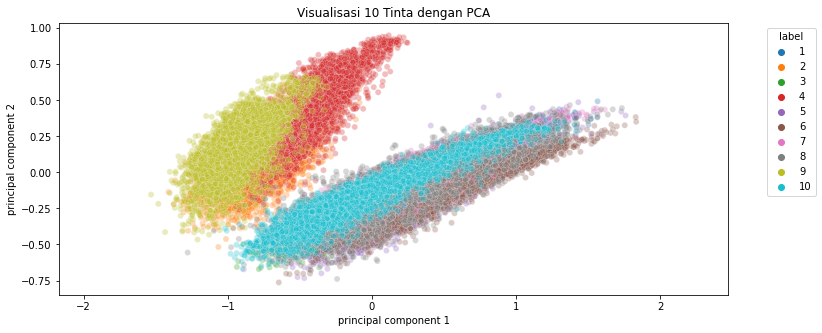

In [575]:
# visualisasi eksperimen utama 10 tinta (PCA)

plot_dots(complete_dfe10, opacity=0.3, axis="equal", target="label", mode="pca", title="Visualisasi 10 Tinta dengan PCA")

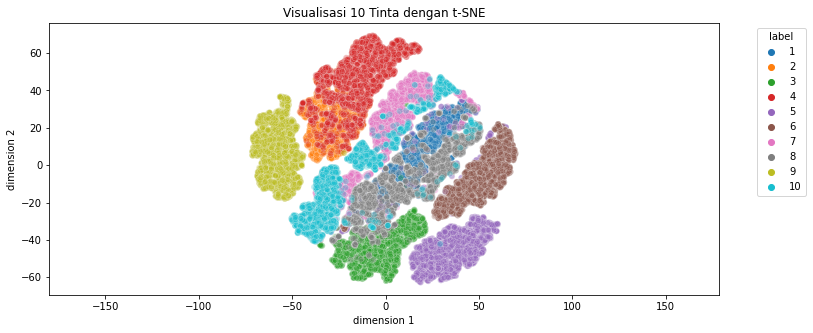

In [578]:
# visualisasi eksperimen pendahuluan 10 tinta (t-SNE)

plot_dots(complete_dfe10, opacity=0.3, axis="equal", target="label", mode="tsne", title="Visualisasi 10 Tinta dengan t-SNE")

### b.1. no dimensionality reduction

In [579]:
dfe10_nodim = eksperimen_nodim(complete_dfe10, k=10)

Time 9.711978197097778


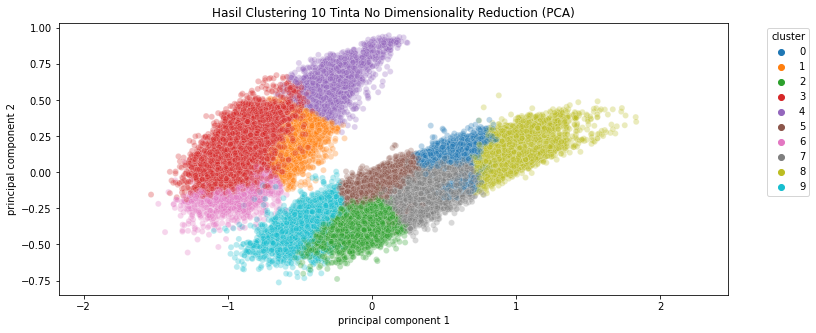

In [581]:
# visualisasi hasil clustering eksperimen utama 10 tinta (PCA)

plot_dots(dfe10_nodim, opacity=0.3, axis="equal", target="cluster", mode="pca", title="Hasil Clustering 10 Tinta No Dimensionality Reduction (PCA)")

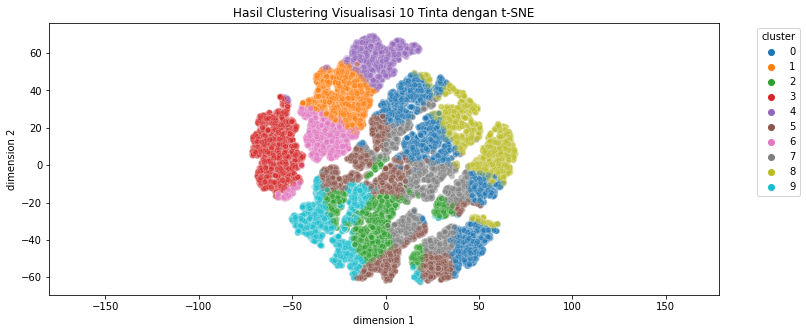

In [583]:
# visualisasi hasil clustering eksperimen utama 10 tinta (t-SNE)

plot_dots(dfe10_nodim, opacity=0.3, axis="equal", target="cluster", mode="tsne", title="Hasil Clustering Visualisasi 10 Tinta dengan t-SNE")

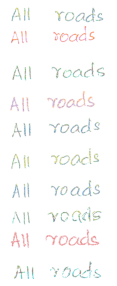

In [589]:
img_dfe10_nodim = visualize_on_image(dfe10_nodim, mask_10tinta, labels=[i for i in range(1,11)], tipe="10 tinta", target="cluster")

### b.2. PCA

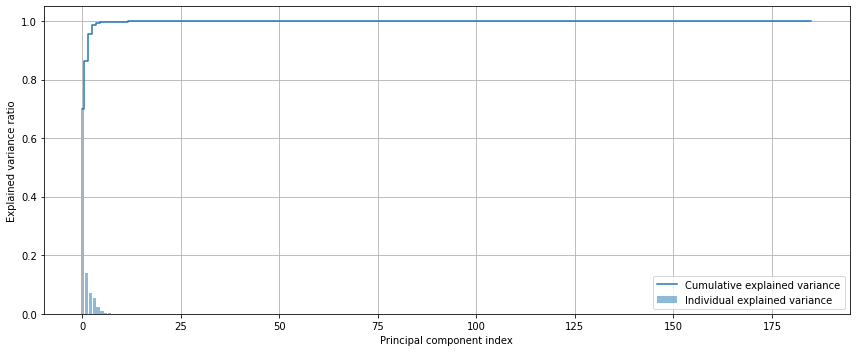

In [590]:
# cek explained variance ratio
# https://vitalflux.com/pca-explained-variance-concept-python-example/

pca = PCA()
X10tinta_train_pca = pca.fit_transform(df_10ink_balance.iloc[:,3:])
exp_var_pca_10tinta = pca.explained_variance_ratio_
cum_sum_eigenvalues_10tinta = np.cumsum(exp_var_pca_3tinta)

plt.rcParams["figure.figsize"] = (12, 5)

plt.bar(range(0,len(exp_var_pca_10tinta)), exp_var_pca_10tinta, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_10tinta)), cum_sum_eigenvalues_10tinta, where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

In [591]:
print("Cumulative explained variace")
print(cum_sum_eigenvalues_10tinta[10])
print("")
print("Individual explained variace")
print(exp_var_pca_10tinta[10])

Cumulative explained variace
0.9980248704306355

Individual explained variace
0.0002737990100277058


In [592]:
dfe10_pca = eksperimen_pca(complete_dfe10, k=10)

Time 3.924168109893799


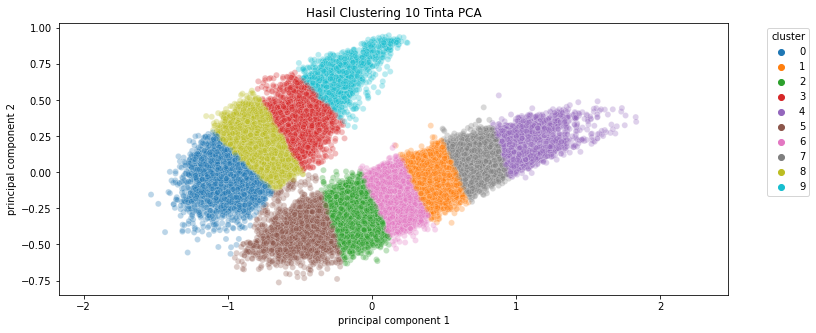

In [593]:
# visualisasi hasil clustering eksperimen utama 10 tinta (PCA)

plot_dots(dfe10_pca, opacity=0.3, axis="equal", target="cluster", mode="pca", title="Hasil Clustering 10 Tinta PCA")

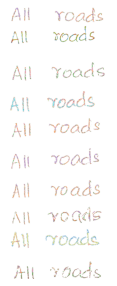

In [594]:
img_dfe10_pca = visualize_on_image(dfe10_pca, mask_10tinta, labels=[i for i in range(1,11)], tipe="10 tinta", target="cluster")

### b.3. t-SNE

In [595]:
dfe10_tsne = eksperimen_tsne(complete_dfe10, k=10)

Time 4.598740339279175


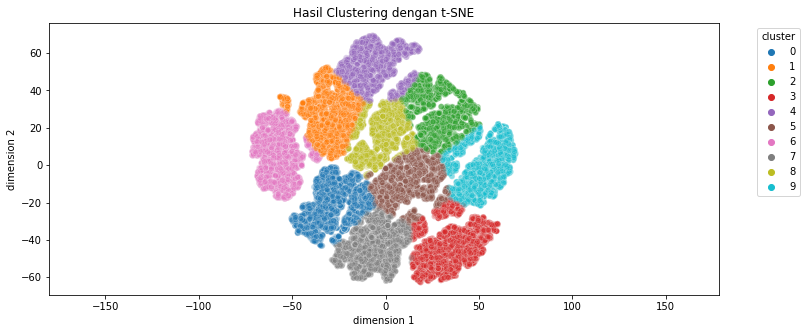

In [596]:
plot_dots(dfe10_tsne, opacity=0.3, axis="equal", mode="tsne", target="cluster", title="Hasil Clustering dengan t-SNE")

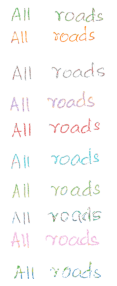

In [597]:
img_dfe10_tsne = visualize_on_image(dfe10_tsne, mask_10tinta, labels=[i for i in range(1,11)], tipe="10 tinta", target="cluster")

# Export

In [604]:
!pip install xlwt

In [605]:
from pandas import ExcelWriter

def save_xls(list_dfs, list_judul, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'%s' % list_judul[n])
        writer.save()

In [606]:
%%time

# export eksperimen pendahuluan

list_dfs_pendahuluan = [
    df_50titik, complete_dfe_penuh, complete_dfe_sebagian,
    dfe_nodim_penuh, dfe_nodim_sebagian,
    dfe_pca_penuh, dfe_pca_sebagian,
    dfe_tsne_penuh, dfe_tsne_sebagian
]

judul_sheets_pendahuluan = [
    "data_50titik", "complete_penuh", "complete_sebagian",
    "nodim_penuh", "nodim_sebagian",
    "pca_penuh", "pca_sebagian",
    "tsne_penuh", "tsne_sebagian"
]

save_xls(list_dfs_pendahuluan, judul_sheets_pendahuluan, "eksperimen_pendahuluan_result.xls")

CPU times: user 1.19 s, sys: 171 ms, total: 1.37 s
Wall time: 1.37 s


In [607]:
%%time

# export eksperimen 3 tinta

list_dfs_3tinta = [
    df_3tinta,
    dfe3_nodim,
    dfe3_pca,
    dfe3_tsne
]

list_judul_3tinta = [
    "df_3tinta",
    "dfe3_nodim",
    "dfe3_pca",
    "dfe3_tsne"
]

save_xls(list_dfs_3tinta, list_judul_3tinta, "eksperimen_3tinta_result.xls")

CPU times: user 58.5 s, sys: 1.4 s, total: 59.9 s
Wall time: 59.9 s


In [610]:
%%time

# merge dfs index 0 - 9

dfs_merged = dfs[0].copy()

for i in range(1,10):
    dfs_merged.append(dfs[i])

CPU times: user 53.3 ms, sys: 20.3 ms, total: 73.5 ms
Wall time: 72.5 ms


In [611]:
%%time

# export 10 tinta

list_dfs_10tinta = [
    dfs_merged,
    df_10ink_balance,
    dfe10_nodim,
    dfe10_pca,
    dfe10_tsne
]

list_judul_10tinta = [
    "df_10ink",
    "df_10ink_balance",
    "dfe10_nodim",
    "dfe10_pca",
    "dfe10_tsne"
]

save_xls(list_dfs_10tinta, list_judul_10tinta, "eksperimen_10tinta_result.xls")

CPU times: user 7min 12s, sys: 14.1 s, total: 7min 26s
Wall time: 7min 27s
